# Faces Age Classification

## Import Libraries and Data Collection

In [6]:
!pip install pykan

In [7]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [59]:
import os
import inspect
import zipfile
from pathlib import Path
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, WeightedRandomSampler
import torch.nn.utils.prune as prune
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from PIL import Image
from kan import *
from sklearn.model_selection import ParameterSampler, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

In [9]:
if running_in_colab:
    print("Running on Google Colab")
    !apt-get update -qq
    !apt-get install -qq git-lfs
    !git lfs install
    !git clone https://github.com/vMxster/Thesis.git
    !cd Thesis && git lfs pull
    zip_part   = "Thesis/Datasets/UTKFace_"
else:
    print("Running locally in Jupyter")
    zip_part   = "Datasets/UTKFace_"

zip_extract_to = "datasets"
os.makedirs(zip_extract_to, exist_ok=True)

for i in range(1,4):
    zip_path = zip_part + str(i) + ".zip"
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(zip_extract_to)

Running on Google Colab
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.
Cloning into 'Thesis'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 90 (delta 22), reused 38 (delta 14), pack-reused 41 (from 1)
Receiving objects: 100% (90/90), 26.08 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Filtering content: 100% (3/3), 1.29 GiB | 23.46 MiB/s, done.


## Data preprocessing

In [10]:
if running_in_colab:
    filenames = glob.glob(f'{zip_extract_to}/*.jpg')
else:
    filenames = [str(p.as_posix()) for p in Path(zip_extract_to).glob(f'*.jpg')]

print(len(filenames))
print(filenames[:3])

24106
['datasets/37_1_0_20170109134008515.jpg', 'datasets/30_1_4_20170103230152025.jpg', 'datasets/3_0_0_20170110211516280.jpg']


In [11]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, ethnic_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0].split('/')[1])
    gender_labels.append(temp[1])
    ethnic_labels.append(temp[2])

In [12]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['ethnic'] = image_path, age_labels, gender_labels, ethnic_labels

df = df[df['age'].str.isdigit()]
df = df[df['gender'].str.isdigit()]
df = df[df['ethnic'].str.isdigit()]

df = df.astype({'age':'int64', 'gender': 'int64', 'ethnic': 'int64'})
df.head()

,image,age,gender,ethnic
0,datasets/2_0_0_20170109194439365.jpg,2,0,0
1,datasets/24_1_2_20170116173550213.jpg,24,1,2
2,datasets/25_1_4_20161221193646742.jpg,25,1,4
3,datasets/36_0_0_20170117184847906.jpg,36,0,0
4,datasets/63_0_0_20170104213557957.jpg,63,0,0


In [13]:
gender_dict = {0:"Male", 1:"Female"}
df = df[df['gender'].isin([0, 1])]
df['gender'] = df['gender'].map(gender_dict)
df['gender'] = df['gender'].astype('category')
df.head()

,image,age,gender,ethnic
0,datasets/2_0_0_20170109194439365.jpg,2,Male,0
1,datasets/24_1_2_20170116173550213.jpg,24,Female,2
2,datasets/25_1_4_20161221193646742.jpg,25,Female,4
3,datasets/36_0_0_20170117184847906.jpg,36,Male,0
4,datasets/63_0_0_20170104213557957.jpg,63,Male,0


In [14]:
ethnic_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
df = df[df['ethnic'].isin([0, 1, 2, 3, 4])]
df['ethnic'] = df['ethnic'].map(ethnic_dict)
df['ethnic'] = df['ethnic'].astype('category')
df.head()

,image,age,gender,ethnic
0,datasets/2_0_0_20170109194439365.jpg,2,Male,White
1,datasets/24_1_2_20170116173550213.jpg,24,Female,Asian
2,datasets/25_1_4_20161221193646742.jpg,25,Female,Others
3,datasets/36_0_0_20170117184847906.jpg,36,Male,White
4,datasets/63_0_0_20170104213557957.jpg,63,Male,White


In [15]:
def age_group(age):
    if age <= 12:
        return 0
    elif age <= 18:
        return 1
    elif age <= 60:
        return 2
    else:
        return 3

df['age_group'] = df['age'].apply(age_group)
df.head()

,image,age,gender,ethnic,age_group
0,datasets/2_0_0_20170109194439365.jpg,2,Male,White,0
1,datasets/24_1_2_20170116173550213.jpg,24,Female,Asian,2
2,datasets/25_1_4_20161221193646742.jpg,25,Female,Others,2
3,datasets/36_0_0_20170117184847906.jpg,36,Male,White,2
4,datasets/63_0_0_20170104213557957.jpg,63,Male,White,3


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24102 entries, 0 to 24105
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   image      24102 non-null  object  
 1   age        24102 non-null  int64   
 2   gender     24102 non-null  category
 3   ethnic     24102 non-null  category
 4   age_group  24102 non-null  int64   
dtypes: category(2), int64(2), object(1)
memory usage: 800.6+ KB


In [17]:
df = df.sample(n=2000, random_state=42)
print(f"Shape of the new dataframe: {df.shape}")

Shape of the new dataframe: (2000, 5)


## Data Exploration

In [18]:
df.drop('image', axis=1).describe(include='all')

,age,gender,ethnic,age_group
count,2000.000000,2000,2000,2000.000000
unique,NaN,2,5,NaN
top,NaN,Male,White,NaN
freq,NaN,1048,830,NaN
mean,32.336500,NaN,NaN,1.729000
std,19.875104,NaN,NaN,0.832409
min,1.000000,NaN,NaN,0.000000
25%,23.000000,NaN,NaN,2.000000
50%,29.000000,NaN,NaN,2.000000
75%,42.000000,NaN,NaN,2.000000


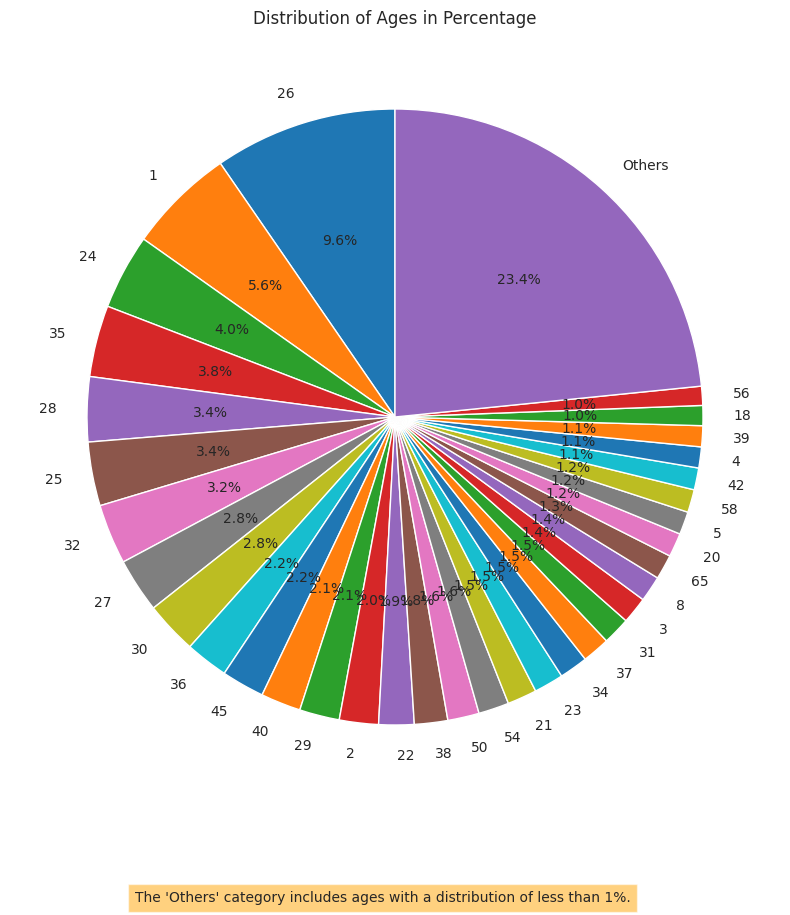

In [19]:
age_counts = df.age.value_counts()
total_count = age_counts.sum()
age_percentages = (age_counts / total_count) * 100

# Identify ages with less than 1%
other_ages = age_percentages[age_percentages < 1]
other_percentage = other_ages.sum()

# Create a new series for plotting
plot_data = age_percentages[age_percentages >= 1]
if other_percentage > 0:
    plot_data['Others'] = other_percentage

sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.title("Distribution of Ages in Percentage")
plot_data.plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.figtext(0.5, 0.01, "The 'Others' category includes ages with a distribution of less than 1%.", ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.show()

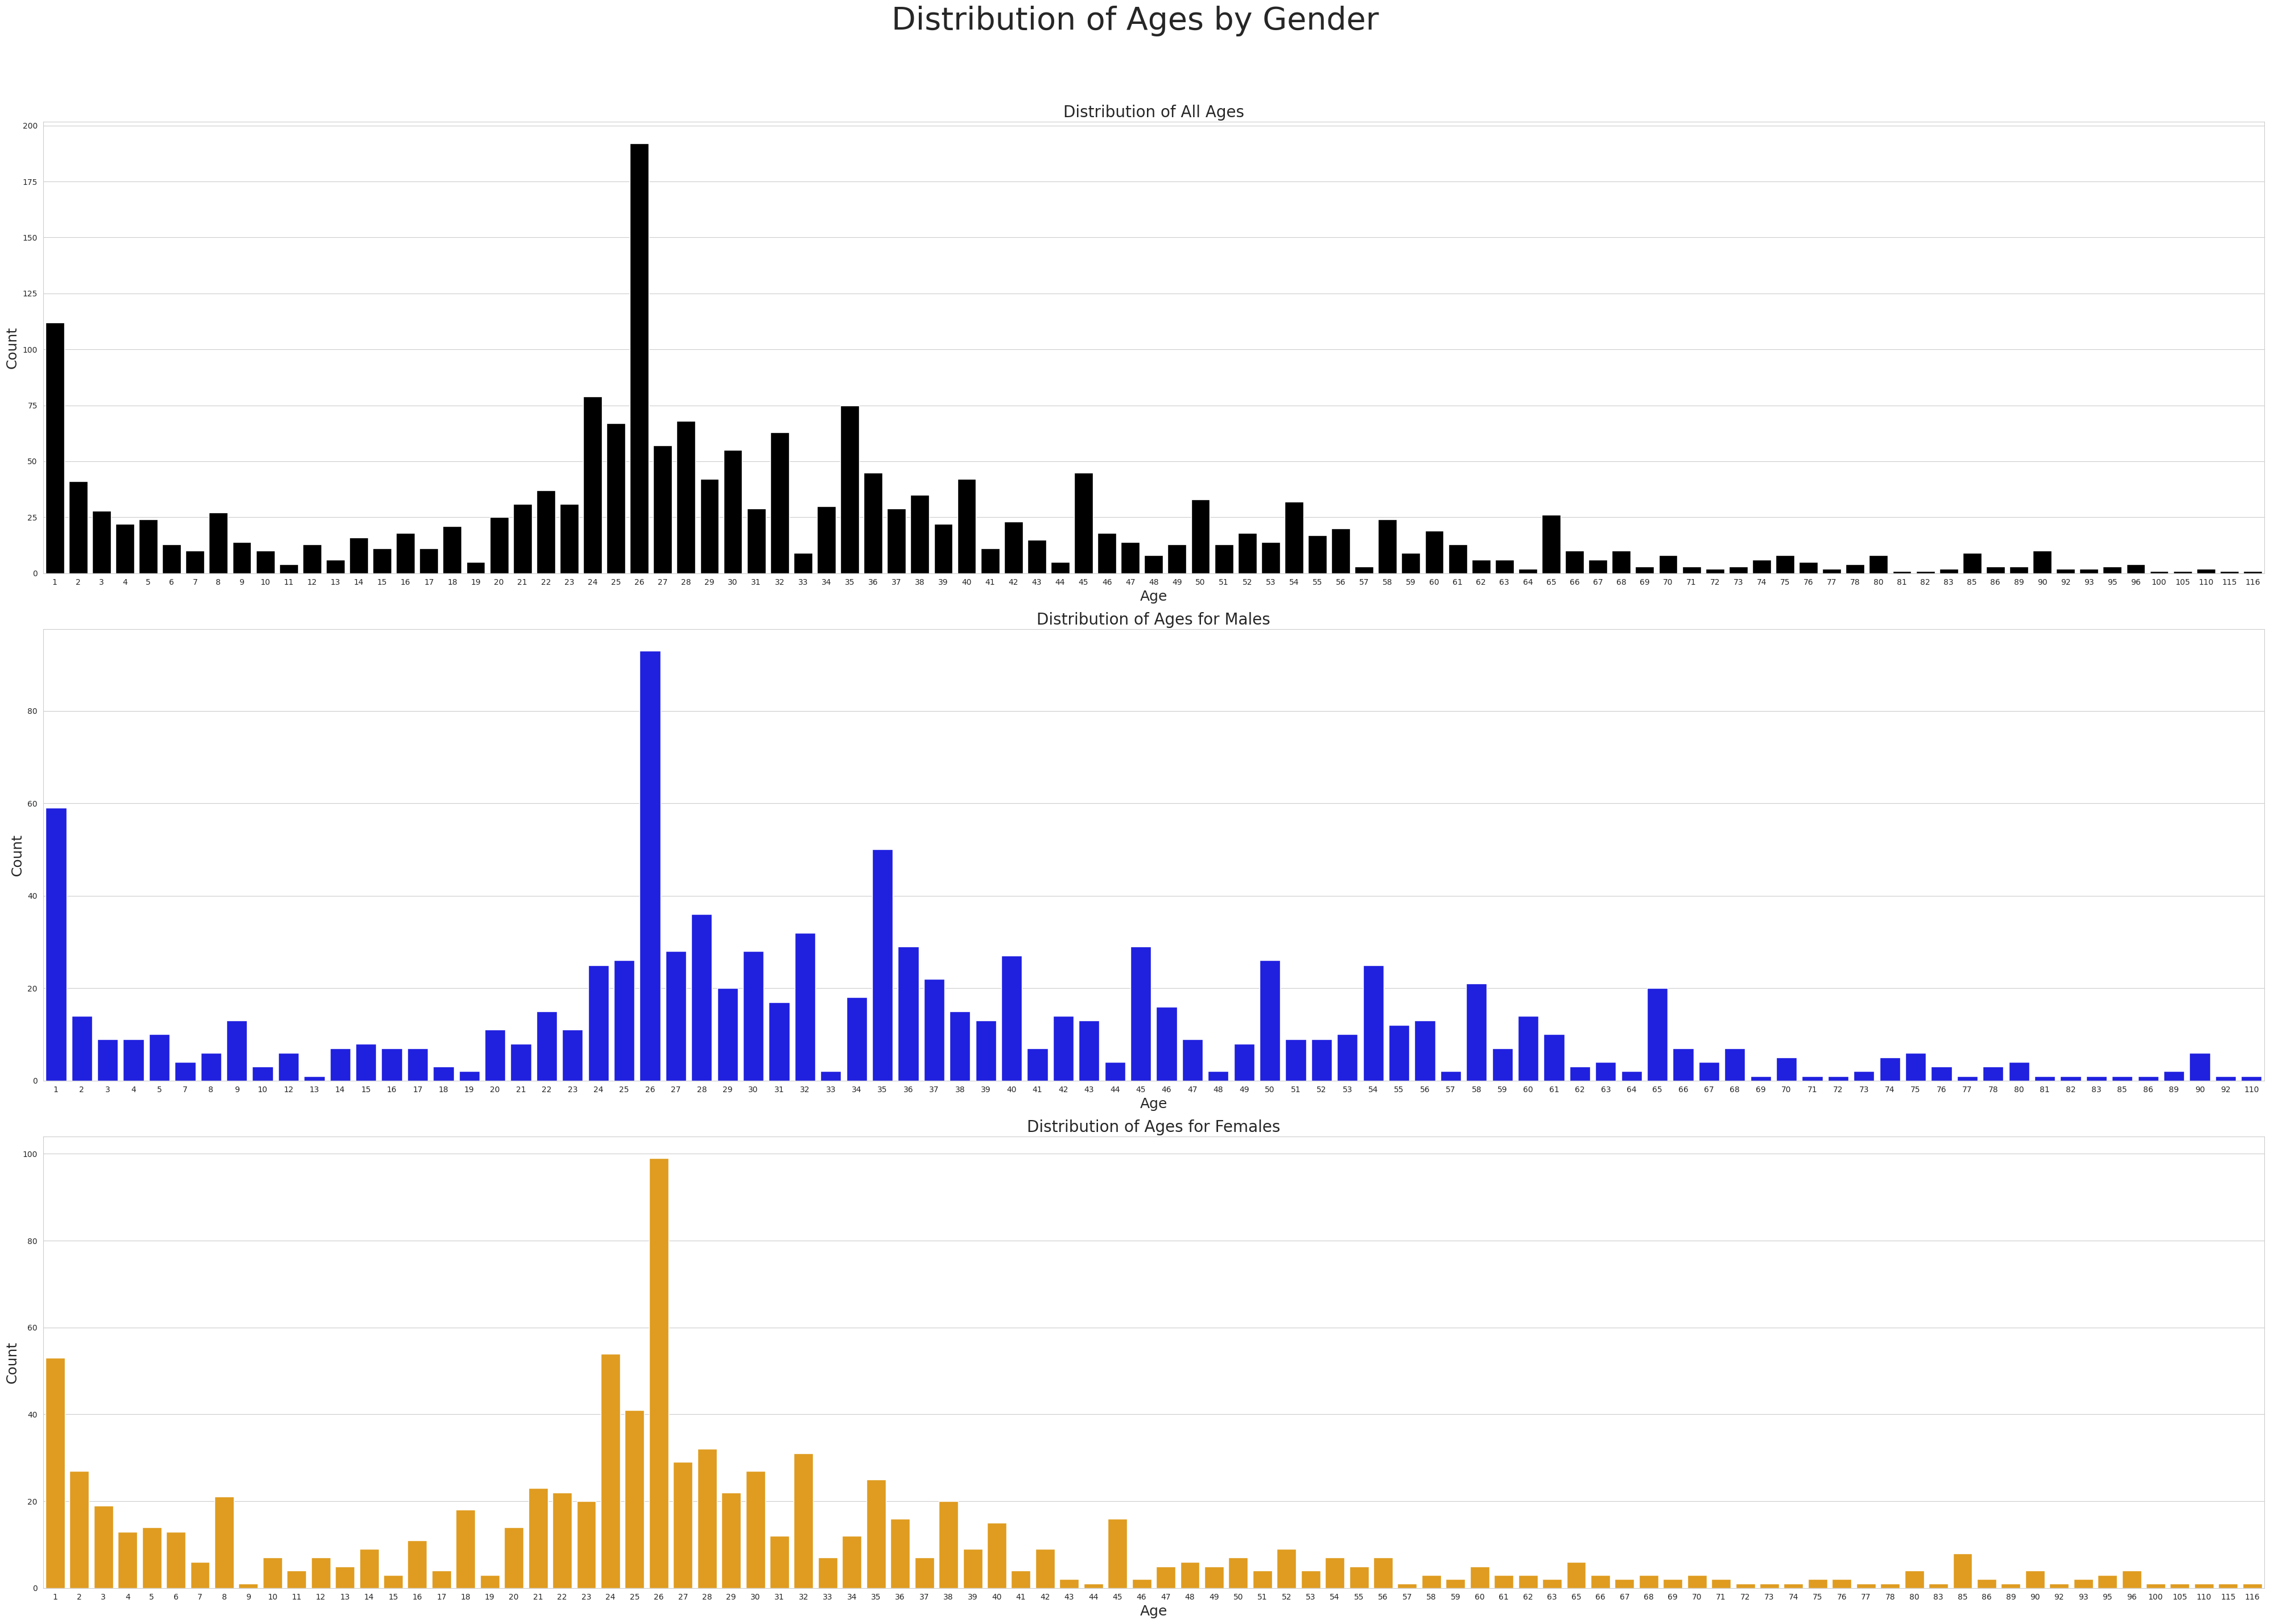

In [20]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(40, 30)) # Create a figure with 3 subplots (3 rows, 1 column)
fig.suptitle("Distribution of Ages by Gender", fontsize=40) # Main title

# Plot for all ages
age_counts = df.age.value_counts()
sns.barplot(x=age_counts.index, y=age_counts.values, ax=axes[0], color='black')
axes[0].set_title("Distribution of All Ages", fontsize=20)
axes[0].set_xlabel("Age", fontsize=18)
axes[0].set_ylabel("Count", fontsize=18)

# Plot for male ages
male_age_counts = df[df.gender == 'Male'].age.value_counts()
sns.barplot(x=male_age_counts.index, y=male_age_counts.values, ax=axes[1], color='blue')
axes[1].set_title("Distribution of Ages for Males", fontsize=20)
axes[1].set_xlabel("Age", fontsize=18)
axes[1].set_ylabel("Count", fontsize=18)

# Plot for female ages
female_age_counts = df[df.gender == 'Female'].age.value_counts()
sns.barplot(x=female_age_counts.index, y=female_age_counts.values, ax=axes[2], color='orange')
axes[2].set_title("Distribution of Ages for Females", fontsize=20)
axes[2].set_xlabel("Age", fontsize=18)
axes[2].set_ylabel("Count", fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent titles overlapping
plt.show()

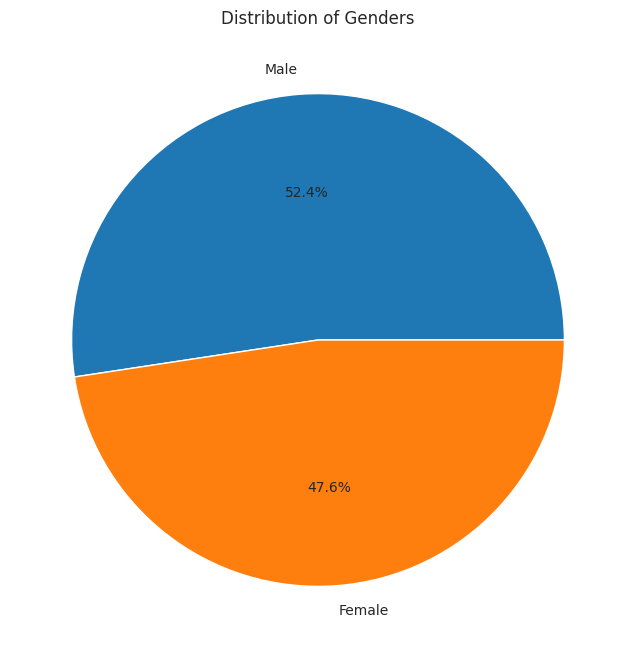

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
plt.title("Distribution of Genders")
plt.pie(df.gender.value_counts(), labels=df.gender.value_counts().index, autopct='%1.1f%%')
plt.show()

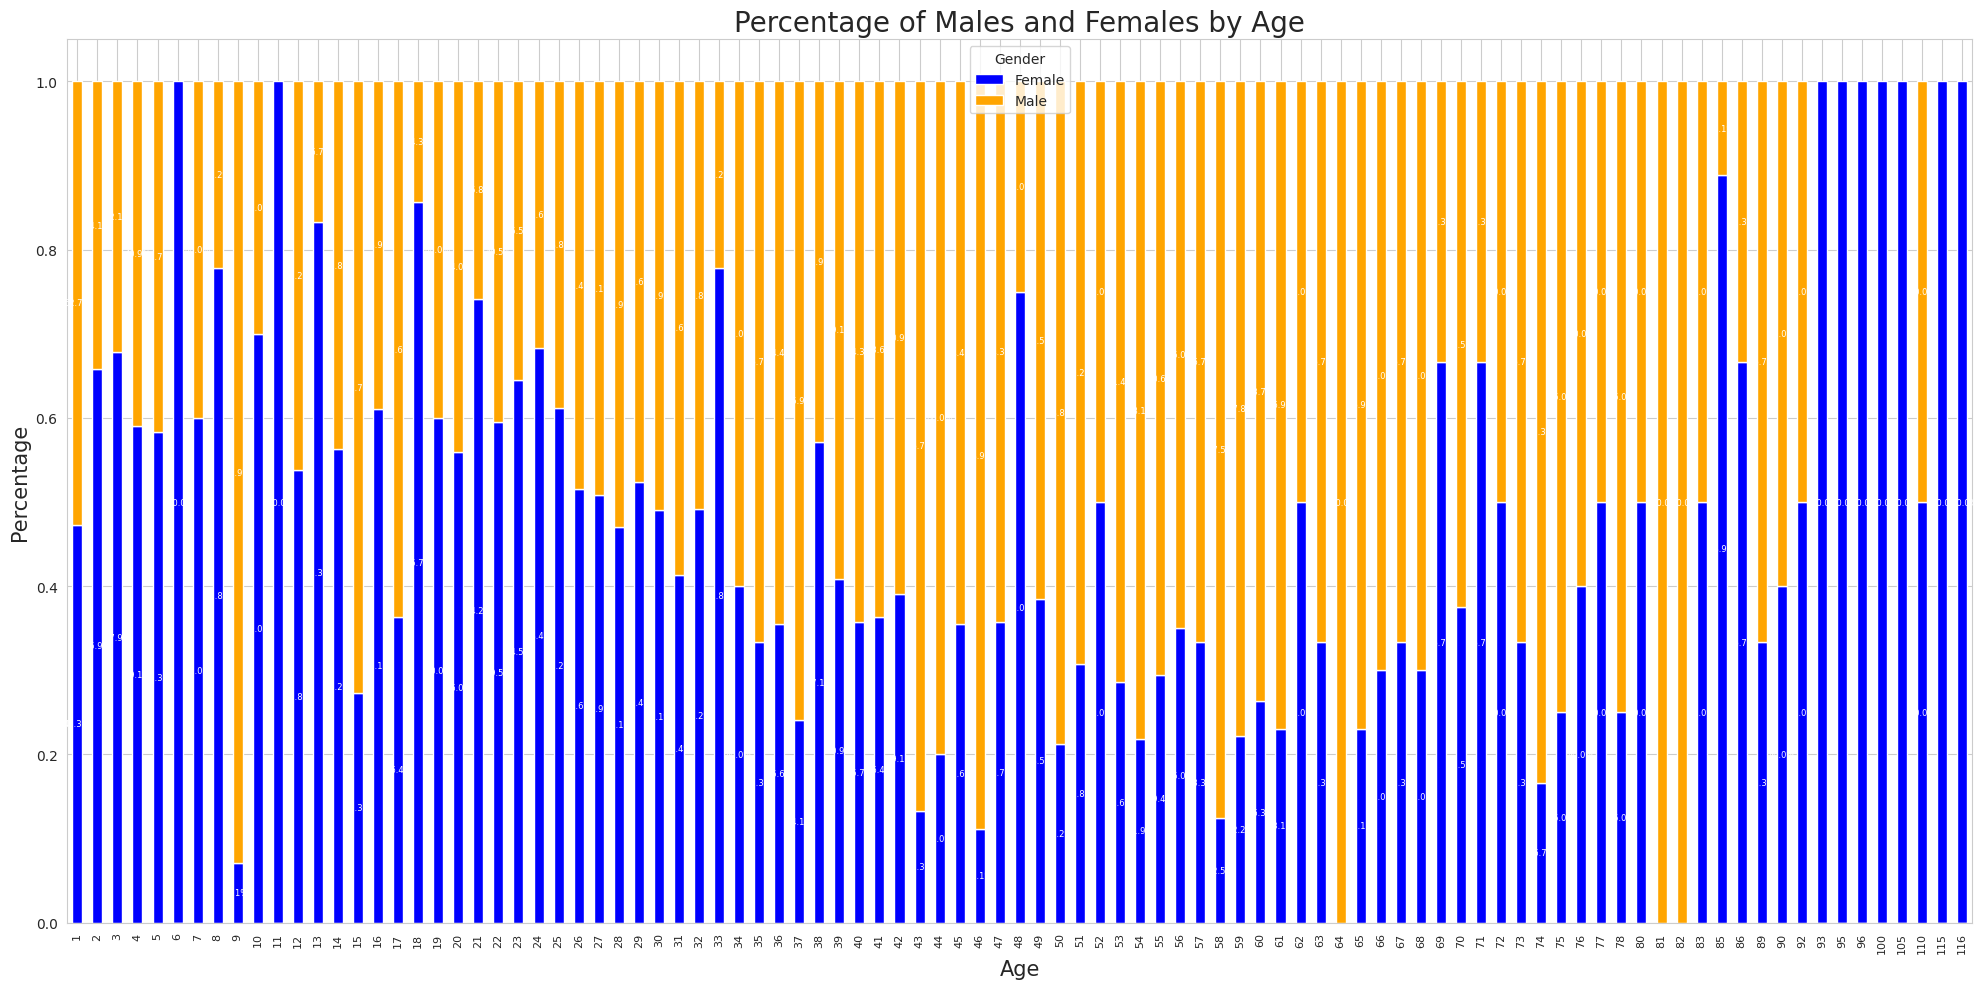

In [22]:
age_gender_counts = df.groupby(['age', 'gender'], observed=True).size().unstack(fill_value=0)
age_gender_percentages = age_gender_counts.apply(lambda x: x / x.sum(), axis=1)

ax = age_gender_percentages.plot(kind='bar', stacked=True, figsize=(20, 10), color=['blue', 'orange'])

plt.title('Percentage of Males and Females by Age', fontsize=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.legend(title='Gender')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:
        x, y = p.get_xy()
        ax.text(x + width / 2,
                y + height / 2,
                '{:.1f}%'.format(height * 100),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=6,
                color='white')

plt.tight_layout()
plt.show()

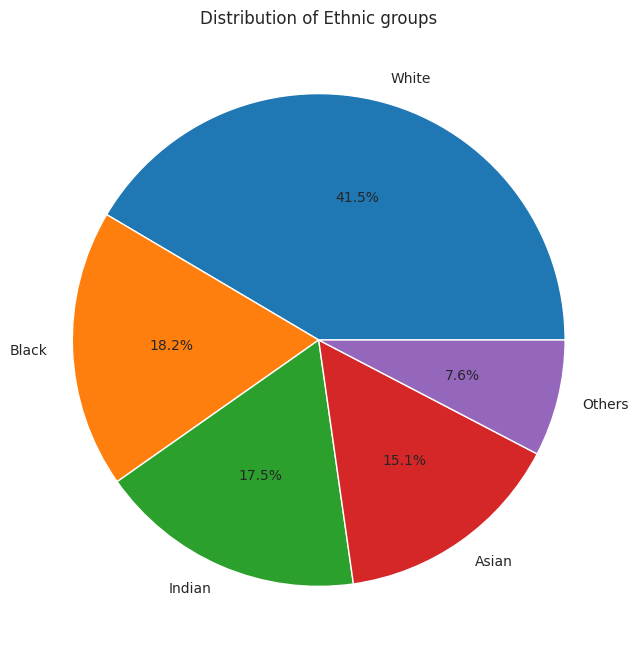

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
plt.title("Distribution of Ethnic groups")
plt.pie(df.ethnic.value_counts(), labels=df.ethnic.value_counts().index, autopct='%1.1f%%')
plt.show()

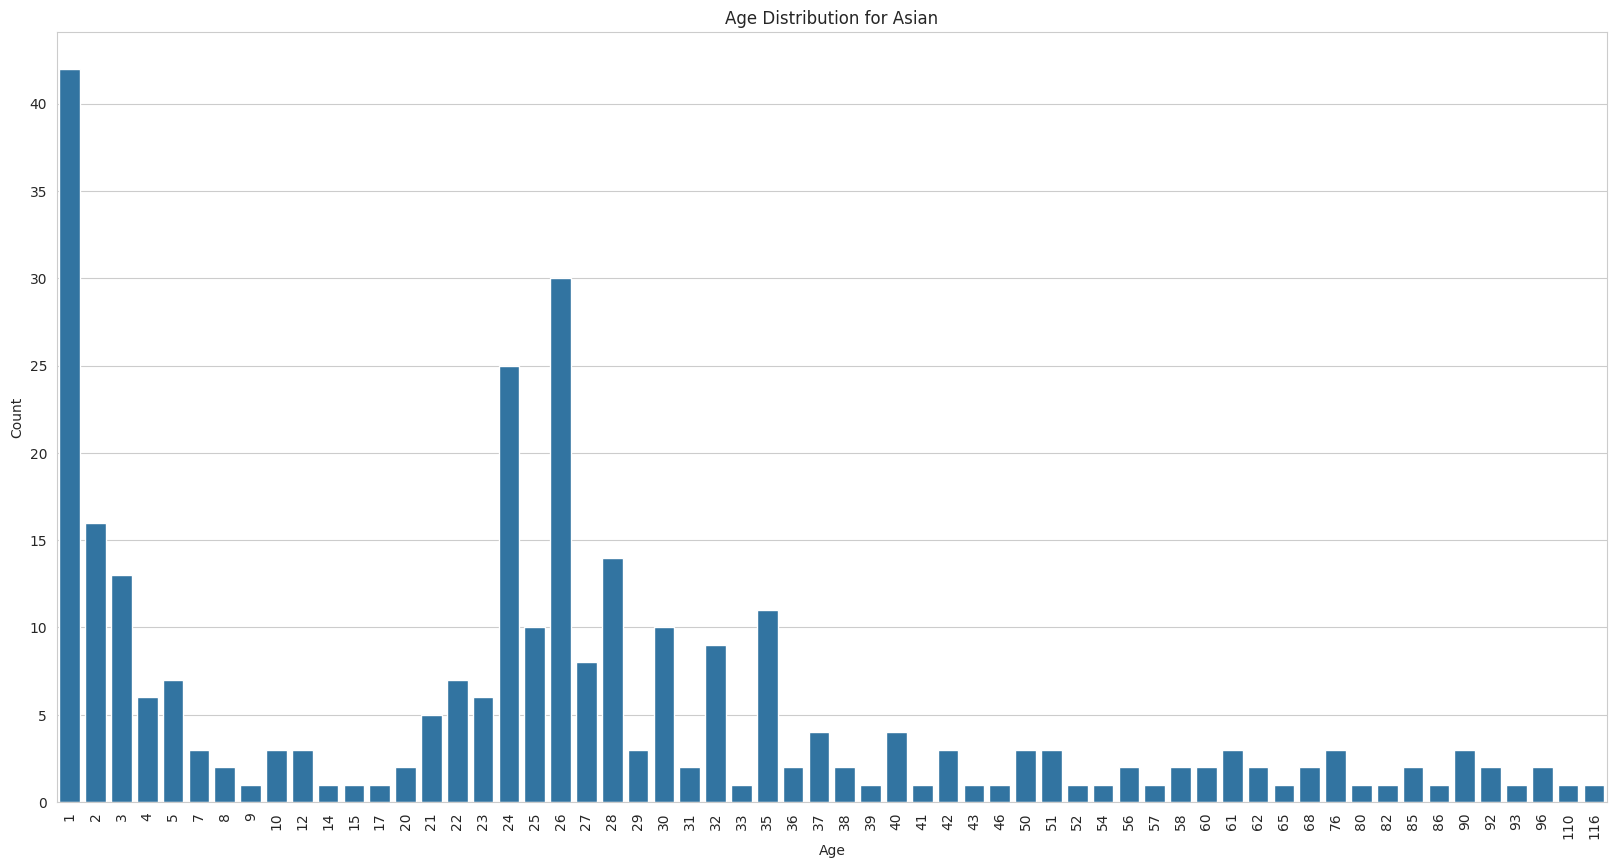

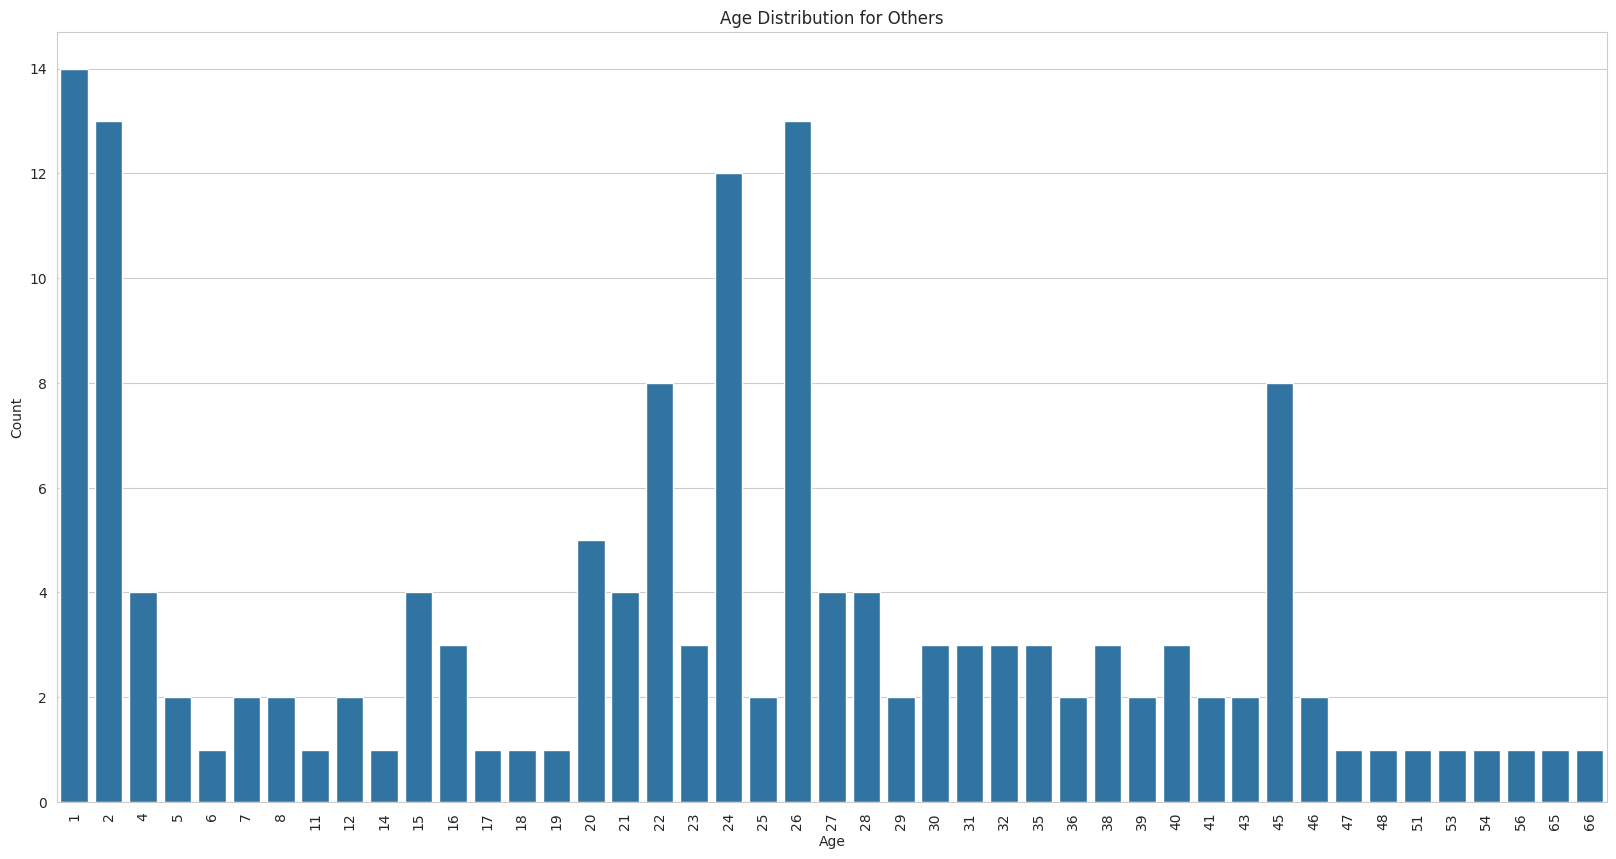

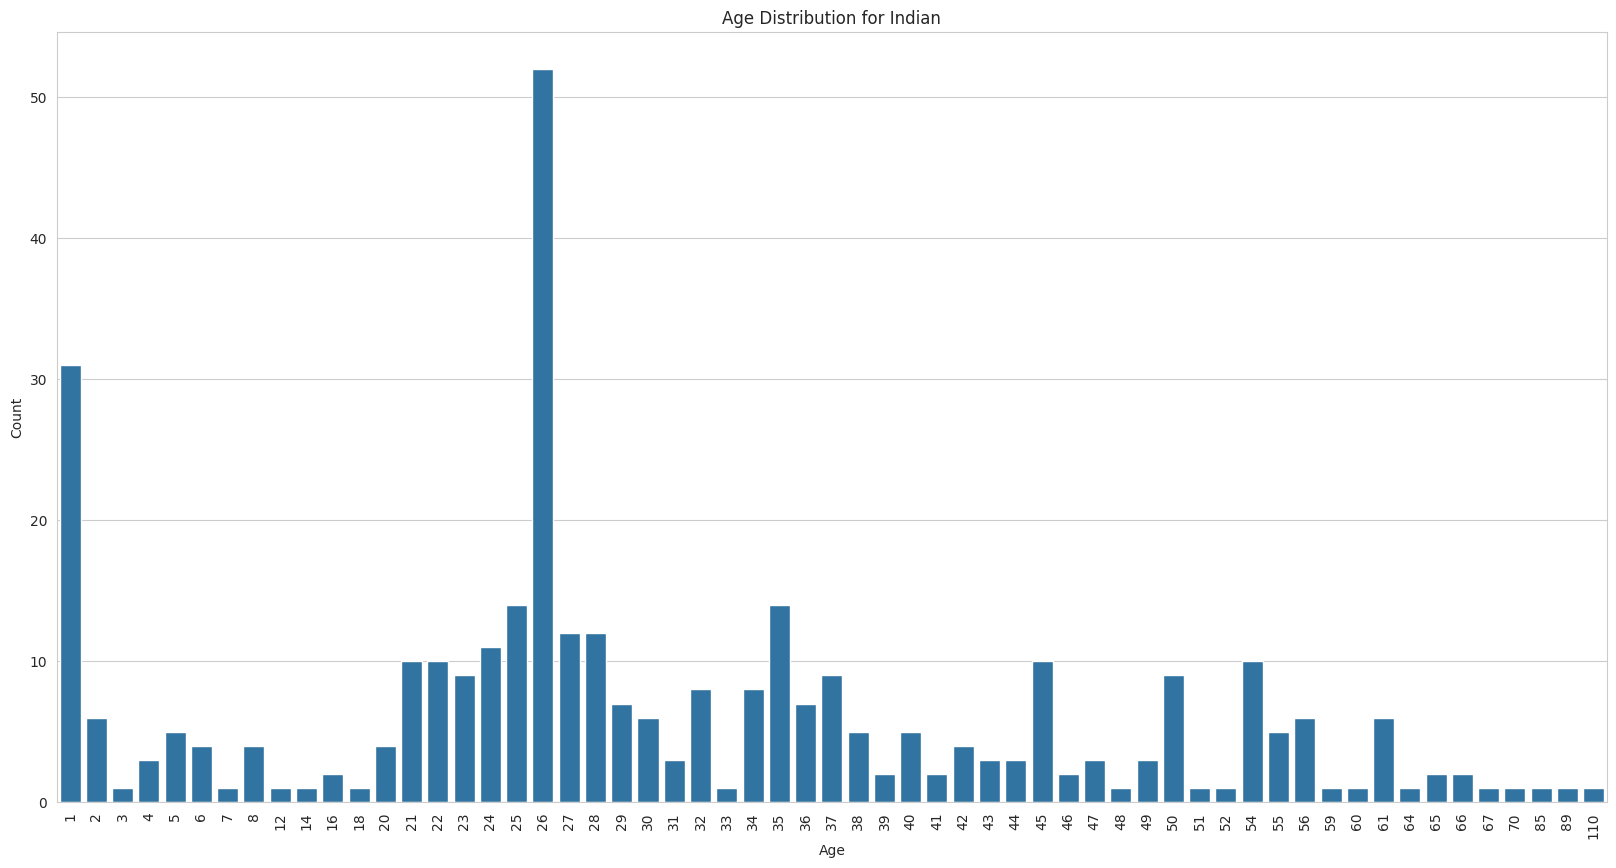

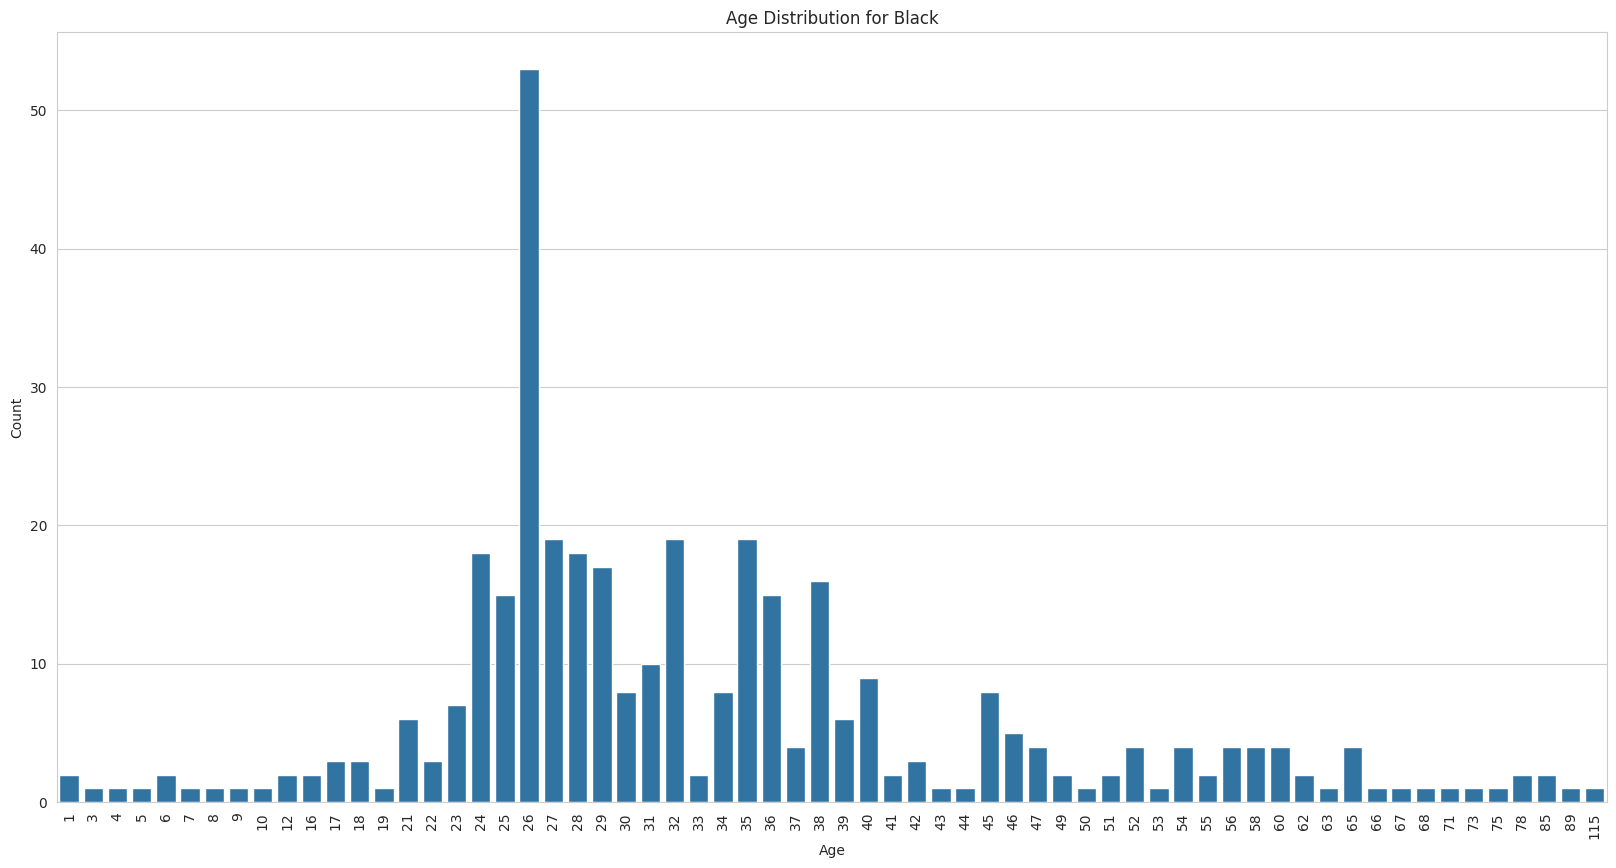

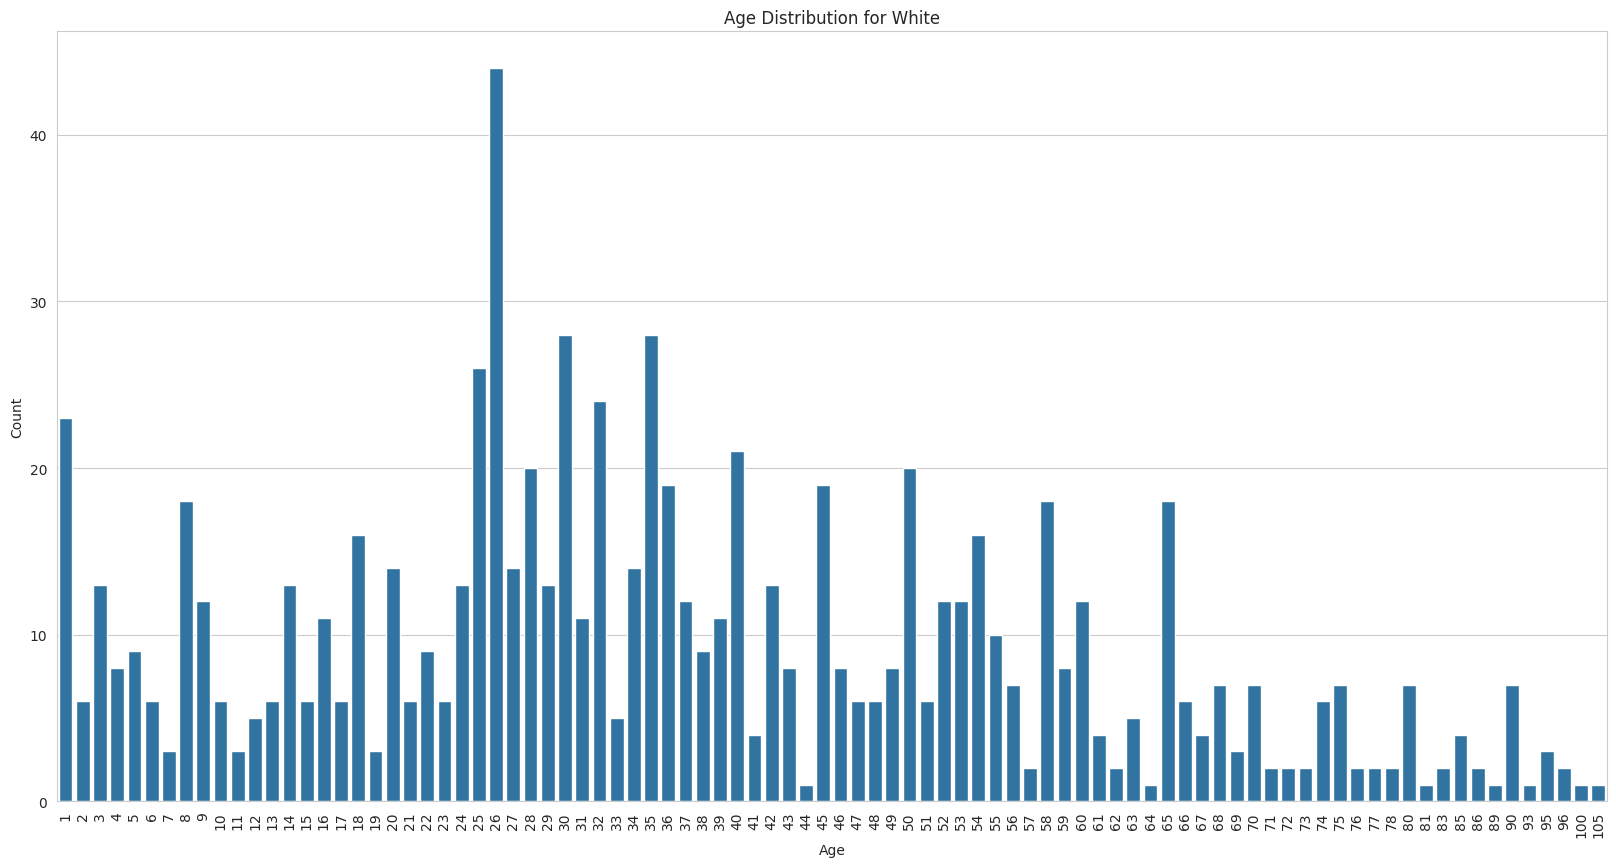

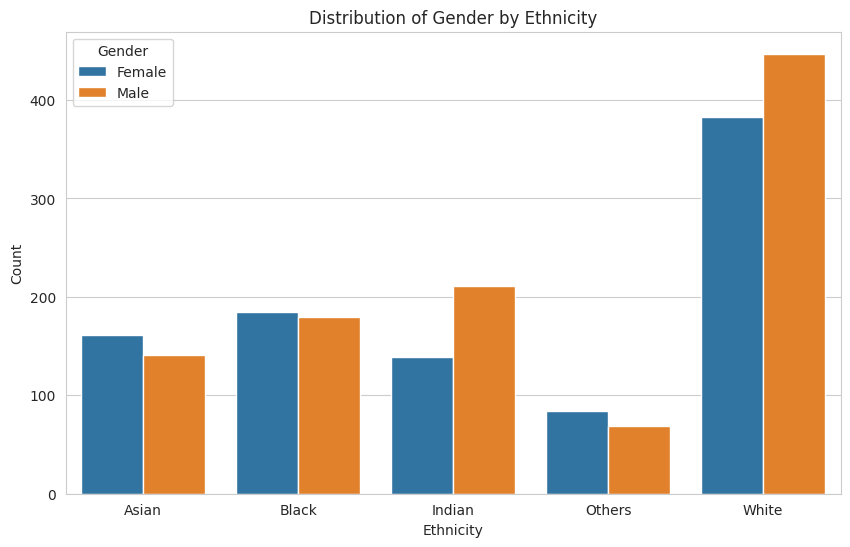

In [24]:
# Bar plot for age and ethnicity
for ethnic_group in df['ethnic'].unique():
    plt.figure(figsize=(20, 10))
    ethnic_df = df[df['ethnic'] == ethnic_group]
    sns.countplot(data=ethnic_df, x='age')
    plt.title(f'Age Distribution for {ethnic_group}')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

# Bar plot for ethnicity and gender
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ethnic', hue='gender')
plt.title('Distribution of Gender by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

age_group
2    1422
0     318
3     177
1      83
Name: count, dtype: int64


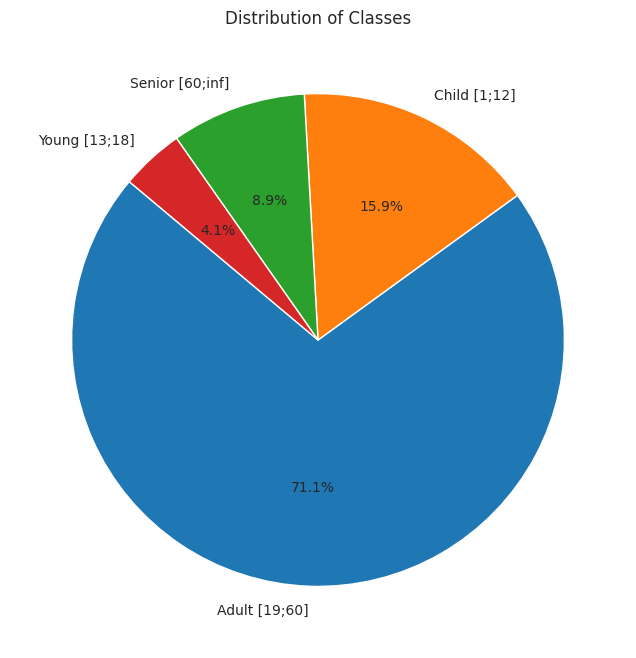

In [25]:
class_counts = df['age_group'].value_counts()
print(class_counts)

age_group_labels = {0: "Child [1;12]", 1: "Young [13;18]", 2: "Adult [19;60]", 3: "Senior [60;inf]"}
pie_labels = [age_group_labels[i] for i in class_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=pie_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

### Plotting Images

Choose one Age in: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86, 89, 90, 92, 93, 95, 96, 100, 105, 110, 115, 116]

Choose one Gender in: ['Female', 'Male']
Categories (2, object): ['Female', 'Male']

Choose one Ethnic (or "All") in: ['Asian', 'Others', 'Indian', 'Black', 'White']
Categories (5, object): ['Asian', 'Black', 'Indian', 'Others', 'White']



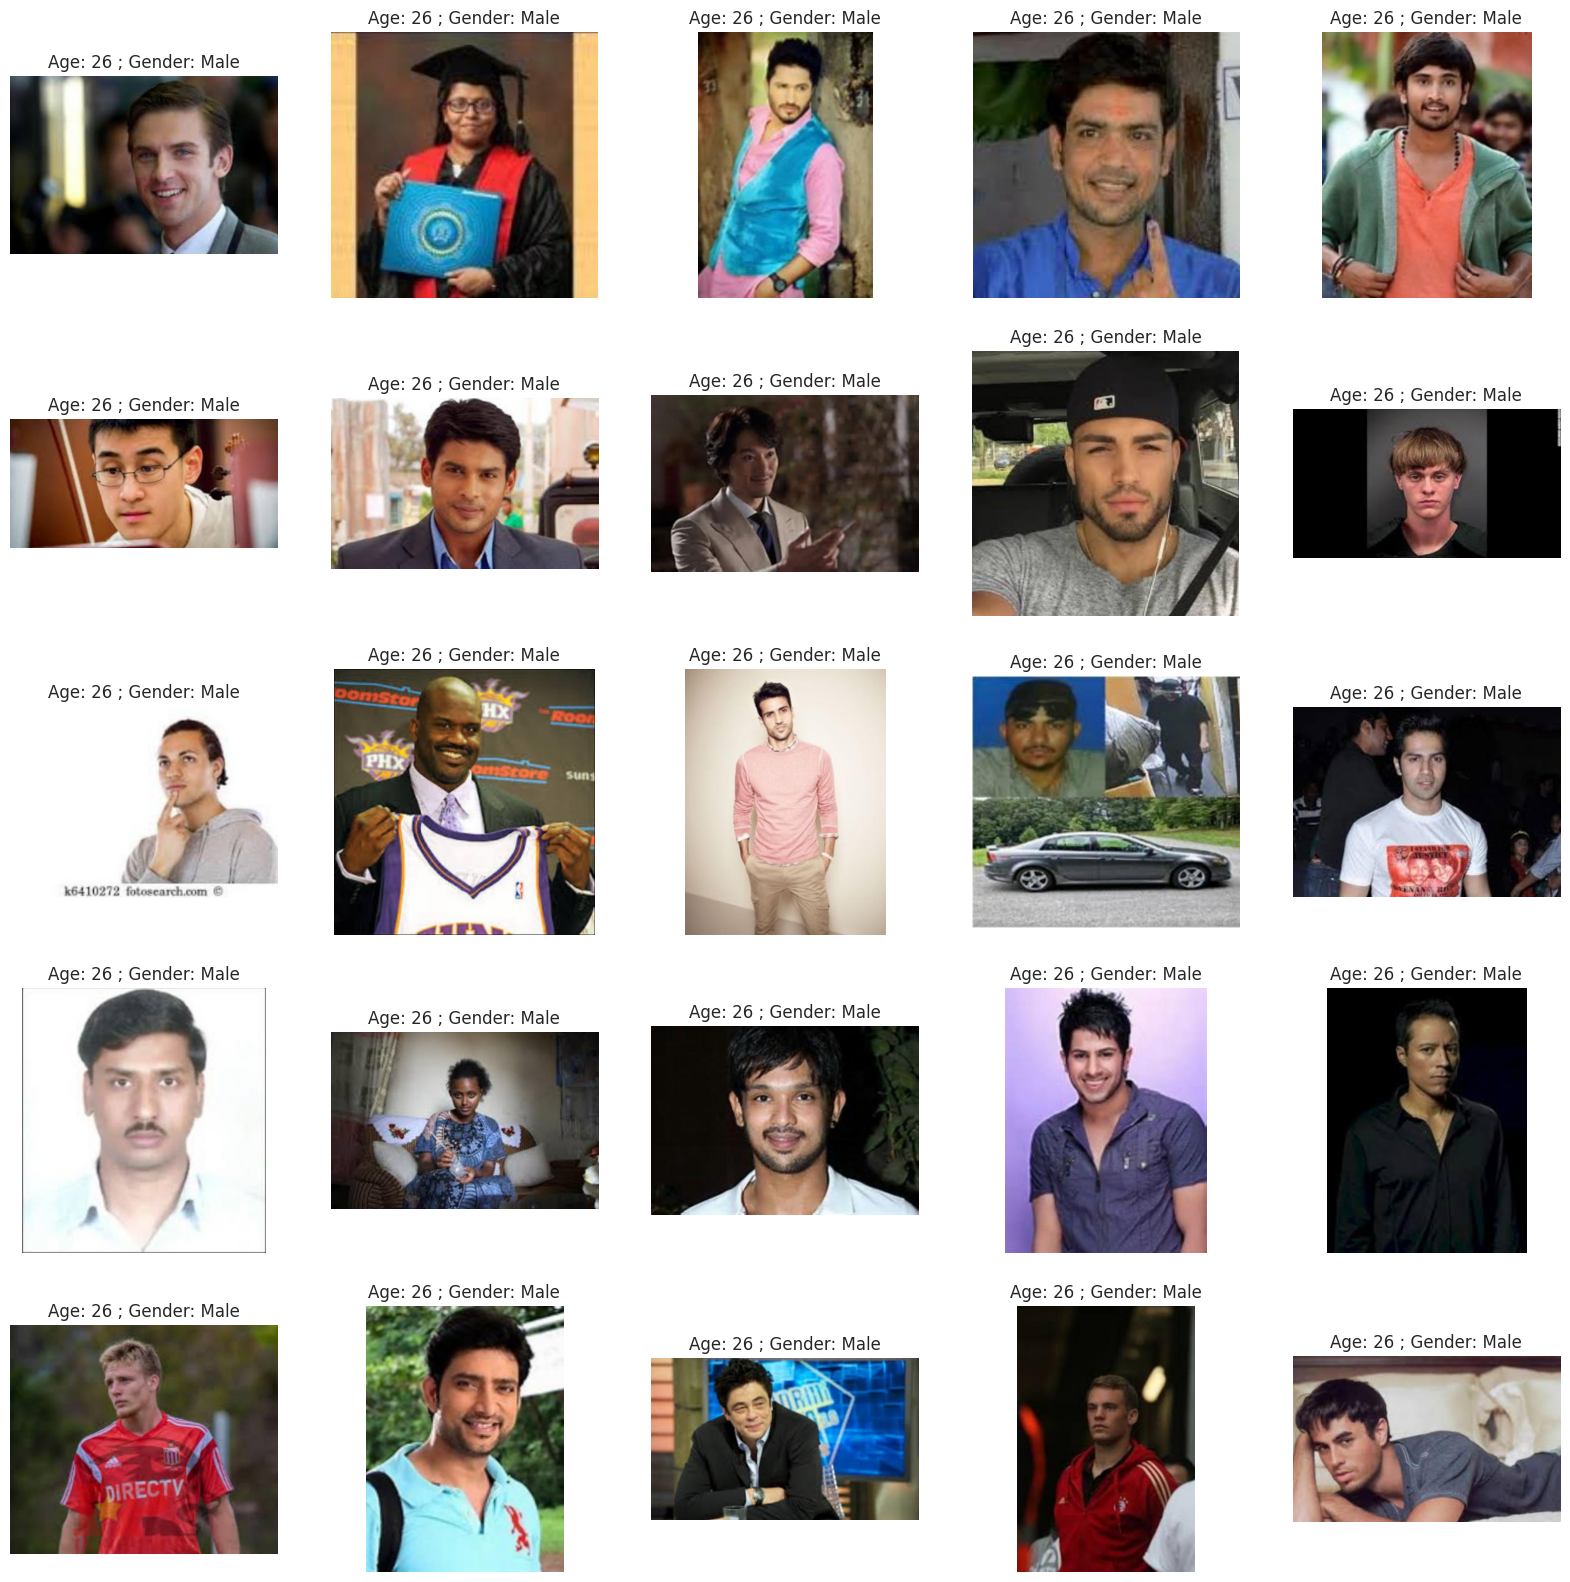

In [26]:
# Options
print(f'Choose one Age in: {sorted([int(age) for age in df["age"].unique()])}\n')
print(f'Choose one Gender in: {df["gender"].unique()}\n')
print(f'Choose one Ethnic (or "All") in: {df["ethnic"].unique()}\n')

# Define Specifics
age = 26
gender = 'Male'
ethnic = 'All'

if ethnic == 'All':
    files = df.loc[(df['gender'] == gender) & (df['age'] == age)]
else:
    files = df.loc[(df['gender'] == gender) & (df['ethnic'] == ethnic) & (df['age'] == age)]

plt.figure(figsize=(20,20))
for i, (index, row) in enumerate(files.head(25).iterrows()):
    plt.subplot(5,5, i+1)
    img = Image.open(row['image'])
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {row['age']} ; Gender: {row['gender']}")
    plt.axis('off')

plt.show()

## Allenamento Modelli

### Definizione Modelli

In [49]:
class CNNFeatureExtractor(nn.Module):
    """Feature extractor CNN basato sull'architettura del primo documento"""
    def __init__(self, input_channels=3):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Per input 224x224, dopo conv1 (3x3, stride 1) e max_pool (2x2):
        # (224 - 3 + 1)/1 = 222, poi 222/2 = 111
        # Dopo conv2 (3x3, stride 1) e max_pool (2x2):
        # (111 - 3 + 1)/1 = 109, poi 109/2 = 54.5 -> floor a 54
        self.feature_dim = 16 * 54 * 54

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.feature_dim)  # Flatten
        return x

class CNN_MLP(nn.Module):
    """CNN + MLP combinato"""
    def __init__(self, input_channels=3, hidden_sizes=[120, 84, 20], dropout=0.0, num_classes=6, device='cpu'):
        super(CNN_MLP, self).__init__()
        self.cnn_features = CNNFeatureExtractor(input_channels)

        # MLP layers
        layers = []
        dim = self.cnn_features.feature_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        features = self.cnn_features(x)
        return self.mlp(features)

class CNN_KAN(nn.Module):
    """CNN + KAN combinato"""
    def __init__(self, input_channels=3, width=[8, 4], grid=5, k=3, num_classes=6, seed=0, device='cpu'):
        super(CNN_KAN, self).__init__()
        self.cnn_features = CNNFeatureExtractor(input_channels)

        # KAN network
        kan_width = [self.cnn_features.feature_dim] + list(width) + [num_classes]
        self.kan = KAN(
            width=kan_width,
            grid=grid,
            k=k,
            seed=seed,
            device=device
        )

    def forward(self, x):
        features = self.cnn_features(x)
        return self.kan(features)

### Definizione Dataset e Split in Train e Test

In [28]:
class ImageDataset(torch.utils.data.Dataset):
    """Dataset personalizzato per immagini con preprocessing"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

        # Transform di default come nel primo documento
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                   [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            img = self.transform(img)
            label = self.labels[idx]
            return img, label
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {self.image_paths[idx]}: {e}")
            # Restituisci un'immagine nera come fallback
            img = torch.zeros(3, 224, 224)
            return img, self.labels[idx]

def create_image_train_test_sets(image_paths, labels, split=0.8):
    """Crea train e test set per le immagini mantenendo l'ordine temporale"""
    dataset_size = len(image_paths)
    train_size = int(dataset_size * split)

    train_paths = image_paths[:train_size]
    test_paths = image_paths[train_size:]
    train_labels = labels[:train_size]
    test_labels = labels[train_size:]

    return train_paths, test_paths, train_labels, test_labels

### EarlyStopper

In [29]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Train ed Eval Functions

In [30]:
def train_cnn_epoch(model, loader, optimizer, criterion, device, l2_lambda=0.0):
    """Training epoch per modelli CNN"""
    model.train()
    total_loss = 0.0
    for batch_idx, (images, labels) in enumerate(tqdm(loader, desc="Training")):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # L2 Regularization
        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

def eval_cnn_loss(model, loader, criterion, device):
    """Valutazione loss per modelli CNN"""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_loss += criterion(outputs, labels).item() * images.size(0)
    return total_loss / len(loader.dataset)

### RandomizedSearch

In [50]:
def random_search_cnn(model_builder, param_dist, train_paths, train_labels,
                      n_iter=10, cv_folds=5, batch_size=32,
                      early_patience=5, early_min_delta=1e-4,
                      class_weights=None, device='cpu'):
    """Random search for CNN models with KFold Cross Validation"""

    train_keys = ['lr', 'l2_lambda']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print("Starting Random Search CNN with KFold Cross Validation...")

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=42)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        # Prepare indices for KFold
        indices = np.arange(len(train_paths))

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            # Create subsets for this fold
            fold_train_paths = [train_paths[i] for i in train_idx]
            fold_train_labels = [train_labels[i] for i in train_idx]
            fold_val_paths = [train_paths[i] for i in val_idx]
            fold_val_labels = [train_labels[i] for i in val_idx]

            # Create dataset for this fold
            train_dataset = ImageDataset(fold_train_paths, fold_train_labels)
            val_dataset = ImageDataset(fold_val_paths, fold_val_labels)

            # Calculate weights for weighted sampling
            if class_weights is not None:
                sample_weights = np.array([class_weights.get(label, 1.0) for label in fold_train_labels])
                sampler = WeightedRandomSampler(
                    weights=sample_weights,
                    num_samples=len(sample_weights),
                    replacement=True
                )
                train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
            else:
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Create and train the model
            if 'width' in model_params:
                model = model_builder(**model_params, device=device)
                if isinstance(model, CNN_KAN):
                    model.kan.speed()
            else:
                model = model_builder(**model_params)
            model.to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(100):
                train_loss = train_cnn_epoch(model, train_loader, optimizer, criterion, device,
                                           l2_lambda=train_params.get('l2_lambda', 0.0))
                val_loss = eval_cnn_loss(model, val_loader, criterion, device)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_cnn_loss(model, val_loader, criterion, device)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            if 'width' in best_model_params:
                best_model = model_builder(**best_model_params, device=device).to(device)
            else:
                best_model = model_builder(**best_model_params).to(device)

            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Calcolo Metriche

In [32]:
def count_params(model):
    if hasattr(model, 'parameters') and inspect.ismethod(model.parameters) and not isinstance(model, KAN):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0

            sum_ab_terms = 0
            for i in range(len(model.width) - 1):
                a = model.width[i]
                b = model.width[i+1]

                if isinstance(a, list):
                    a = a[0]
                if isinstance(b, list):
                    b = b[0]

                sum_ab_terms += (a * b)

            return sum_ab_terms * (model.grid + model.k)
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0
    else:
        return 0

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_cnn_estimator_scores(model_name, model, test_paths, test_labels,
                           train_paths, train_labels, device, batch_size=32):
    """Valutazione prestazioni per modelli CNN - stile secondo documento"""
    print(f"\n--- Valutazione Prestazioni per {model_name} (CNN) ---")

    # Calcola parametri del modello
    param_count = count_params(model)
    print(f"Model Parameters: {param_count}")

    # Crea dataset e dataloader
    train_dataset = ImageDataset(train_paths, train_labels)
    test_dataset = ImageDataset(test_paths, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Predizioni
    model.eval()
    y_pred_train, y_true_train = [], []
    y_pred_test, y_true_test = [], []
    y_proba_test = []

    with torch.no_grad():
        # Training set
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            y_pred_train.extend(pred.cpu().numpy())
            y_true_train.extend(labels.cpu().numpy())

        # Test set
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            proba = F.softmax(outputs, dim=1)

            y_pred_test.extend(pred.cpu().numpy())
            y_true_test.extend(labels.cpu().numpy())
            y_proba_test.extend(proba.cpu().numpy())

    y_proba_test = np.array(y_proba_test)

    # Calcola metriche
    accuracy_tr = accuracy_score(y_true_train, y_pred_train)
    f1_weighted_tr = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_true_train, y_pred_train, average='macro', zero_division=0)

    accuracy_te = accuracy_score(y_true_test, y_pred_test)
    f1_weighted_te = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_true_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_true_test, y_pred_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_true_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_true_test, y_pred_test))

    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC
    try:
        auc_roc_ovr = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')

        # Bootstrap per AUC
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
            y_true_test, y_proba_test
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
            y_true_test, y_proba_test
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

    all_scores.append(scores_row)

### Preparazione Dati, Definizione Griglia ed Allenamento Modelli

**Scelta del numero di iterazioni per RandomizedSearchCV con CNN_MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 54
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 54.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{54}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{44}{54}\right)} = \frac{-2.3026}{\ln(\frac{44}{54})} \approx \frac{2.3026}{0.2047} \approx 11.25
$$

Quindi, con **11 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 54 combinazioni.

---


**Scelta del numero di iterazioni per RandomizedSearchCV con CNN_KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 72
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 72.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{72}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{62}{72}\right)} = \frac{-2.3026}{\ln(\frac{62}{72})} \approx \frac{2.3026}{0.1495} \approx 15.40
$$

Quindi, con **15 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 72 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

image_paths = list(df['image'])
labels = list(df['age_group'].astype('category').cat.codes)

# Dividi in train/test
train_paths, test_paths, train_labels, test_labels = create_image_train_test_sets(
    image_paths, labels, split=0.8
)

# Calcola pesi delle classi
class_labels = np.unique(train_labels)
class_weights_balanced = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_labels
)
class_weights_dict = dict(zip(class_labels, class_weights_balanced))

# Definisci spazi di ricerca iperparametri
num_classes = len(class_labels)

all_scores = []

Device utilizzato: cuda


In [37]:
cnn_mlp_param_dist = {
    'input_channels': [3],
    'hidden_sizes': [[120, 84, 20], [64, 32], [128, 64, 32]],
    'dropout': [0.0, 0.2, 0.5],
    'num_classes': [num_classes],
    'lr': [1e-3, 1e-4],
    'l2_lambda': [0.0, 1e-5, 1e-4]
}

cnn_kan_param_dist = {
    'input_channels': [3],
    'width': [[8, 4], [16, 8], [32, 16]],
    'grid': [5, 10],
    'k': [2, 3],
    'num_classes': [num_classes],
    'seed': [0],
    'lr': [1e-3, 1e-4],
    'l2_lambda': [0.0, 1e-5, 1e-4]
}

In [51]:
# Addestramento CNN+MLP
print("=== CNN + MLP Results ===")
best_cnn_mlp, model_params_cnn_mlp, train_params_cnn_mlp = random_search_cnn(
    lambda **p: CNN_MLP(**p),
    cnn_mlp_param_dist,
    train_paths,
    train_labels,
    class_weights=class_weights_dict,
    device=device,
    n_iter=1
)

get_cnn_estimator_scores("CNN_MLP", best_cnn_mlp,
                        test_paths, test_labels,
                        train_paths, train_labels,
                        device)

=== CNN + MLP Results ===
Starting Random Search CNN with KFold Cross Validation...
Testing parameter set 1/11
  Fold 1/5


Training: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


    Epoch 0: train_loss = 1.372288, val_loss = 1.294730


Training:  48%|████▊     | 19/40 [00:05<00:06,  3.38it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3737708127.py", line 3, in <cell line: 0>
    best_cnn_mlp, model_params_cnn_mlp, train_params_cnn_mlp = random_search_cnn(
                                                               ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3073164881.py", line 67, in random_search_cnn
    train_loss = train_cnn_epoch(model, train_loader, optimizer, criterion, device,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-519674433.py", line 5, in train_cnn_epoch
    for batch_idx, (images, labels) in enumerate(tqdm(loader, desc="Training")):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

TypeError: object of type 'NoneType' has no len()

In [38]:
# Addestramento CNN+KAN
print("\n=== CNN + KAN Results ===")
best_cnn_kan, model_params_cnn_kan, train_params_cnn_kan = random_search_cnn(
    lambda **p: CNN_KAN(**p),
    cnn_kan_param_dist,
    train_paths,
    train_labels,
    class_weights=class_weights_dict,
    device=device,
    n_iter=15
)

get_cnn_estimator_scores("CNN_KAN", best_cnn_kan,
                        test_paths, test_labels,
                        train_paths, train_labels,
                        device)


=== CNN + KAN Results ===
Starting Random Search CNN with KFold Cross Validation...
Testing parameter set 1/1
  Fold 1/5
checkpoint directory created: ./model
saving model version 0.0


Training: 100%|██████████| 40/40 [00:18<00:00,  2.20it/s]


    Epoch 0: train_loss = 1.295504, val_loss = 1.379482


Training: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


    Epoch 10: train_loss = 0.399556, val_loss = 1.310433


Training: 100%|██████████| 40/40 [00:19<00:00,  2.10it/s]


    Early stopping at epoch 17, best_val_loss: 1.073936
  Fold 2/5
checkpoint directory created: ./model
saving model version 0.0


Training: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


    Epoch 0: train_loss = 1.288537, val_loss = 1.288440


Training: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


    Epoch 10: train_loss = 0.423945, val_loss = 1.092513


Training: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


    Early stopping at epoch 11, best_val_loss: 1.003036
  Fold 3/5
checkpoint directory created: ./model
saving model version 0.0


Training: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s]


    Epoch 0: train_loss = 1.284671, val_loss = 1.434032


Training: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


    Epoch 10: train_loss = 0.406393, val_loss = 1.205566


Training: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


    Early stopping at epoch 12, best_val_loss: 1.049455
  Fold 4/5
checkpoint directory created: ./model
saving model version 0.0


Training: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s]


    Epoch 0: train_loss = 1.309114, val_loss = 1.464394


Training: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


    Epoch 10: train_loss = 0.364000, val_loss = 1.037368


Training: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


    Early stopping at epoch 14, best_val_loss: 1.010228
  Fold 5/5
checkpoint directory created: ./model
saving model version 0.0


Training: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


    Epoch 0: train_loss = 1.327674, val_loss = 1.384032


Training: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


    Epoch 10: train_loss = 0.435697, val_loss = 1.201422


Training: 100%|██████████| 40/40 [00:17<00:00,  2.23it/s]


    Early stopping at epoch 16, best_val_loss: 1.097369
  Mean validation loss: 1.139865
checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 1.139865

Best validation loss: 1.139865

--- Valutazione Prestazioni per CNN_KAN (CNN) ---
Model Parameters: 9707576

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.36      0.48      0.41        61
           1       0.10      0.06      0.07        17
           2       0.80      0.63      0.71       281
           3       0.25      0.54      0.34        41

    accuracy                           0.57       400
   macro avg       0.38      0.43      0.38       400
weighted avg       0.65      0.57      0.60       400


Confusion Matrix (Test Set):
[[ 29   2  21   9]
 [  4   1  10   2]
 [ 43   6 178  54]
 [  4   1  14  22]]
AUC-ROC (OVR, Weighted): 0.702
AUC-PR (OVR, Weighted): 0.681


## Confronto Visivo delle Prestazioni dei Modelli

In [52]:
def plot_estimator_scores(scores):
    # Prepariamo i dati per il plot di Accuracy (Train vs Test)
    melted_accuracy = (
        scores[['Model', 'Accuracy_Train', 'Accuracy_Test']]
        .rename(columns={'Accuracy_Train': 'Train', 'Accuracy_Test': 'Test'})
        .melt(id_vars='Model', var_name='Set', value_name='Score')
    )

    model_order = scores['Model'].tolist()

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.tight_layout(pad=4.0)

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy')
    sns.barplot(data=melted_accuracy, x='Score', y='Model', hue='Set', ax=axs[0, 0], order=model_order)
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].legend(loc='lower right', title='Set')
    axs[0, 0].set_xlim(0, 1)

    # --- Funzione helper per disegnare barh con CI in modo consistente ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order):
        ax.set_title(title)
        # Assicurati che i dati siano ordinati per il plot coerente
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            # Gestisci i valori NaN per i CI
            val = row[metric_col]
            if pd.isna(val):
                continue # Salta il modello se il valore della metrica è NaN

            err_low = [val - row[ci_low_col]] if not pd.isna(row[ci_low_col]) else [0]
            err_high = [row[ci_high_col] - val] if not pd.isna(row[ci_high_col]) else [0]

            ax.barh(
                row['Model'], val,
                xerr=[err_low, err_high],
                capsize=5,
                color=sns.color_palette("viridis")[i % len(sns.color_palette("viridis"))] # Colore coerente
            )
        ax.set_xlabel(title.split(' ')[0]) # Estrae il nome della metrica dal titolo
        ax.invert_yaxis() # Per avere lo stesso ordine dei modelli sull'asse y
        ax.set_xlim(0, 1) # Imposta i limiti per le metriche [0, 1]

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order)

    # --- Plot 6: Model Complexity (Parameter/Node Count) ---
    axs[1, 2].set_title('Model Complexity (Parameters/Nodes)', fontsize=12, fontweight='bold')

    # Order data by model order for consistency
    scores_ordered = scores.set_index('Model').loc[model_order].reset_index()

    # Create color palette
    colors = sns.color_palette("plasma", len(scores_ordered))

    bars = axs[1, 2].barh(scores_ordered['Model'], scores_ordered['Param_Count'], color=colors)
    axs[1, 2].set_xlabel('Parameter/Node Count')
    axs[1, 2].invert_yaxis()

    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, scores_ordered['Param_Count'])):
        if not pd.isna(count) and count > 0:
            axs[1, 2].text(bar.get_width() + max(scores_ordered['Param_Count']) * 0.01,
                          bar.get_y() + bar.get_height()/2,
                          f'{int(count):,}',
                          va='center', fontsize=9)

    plt.show()

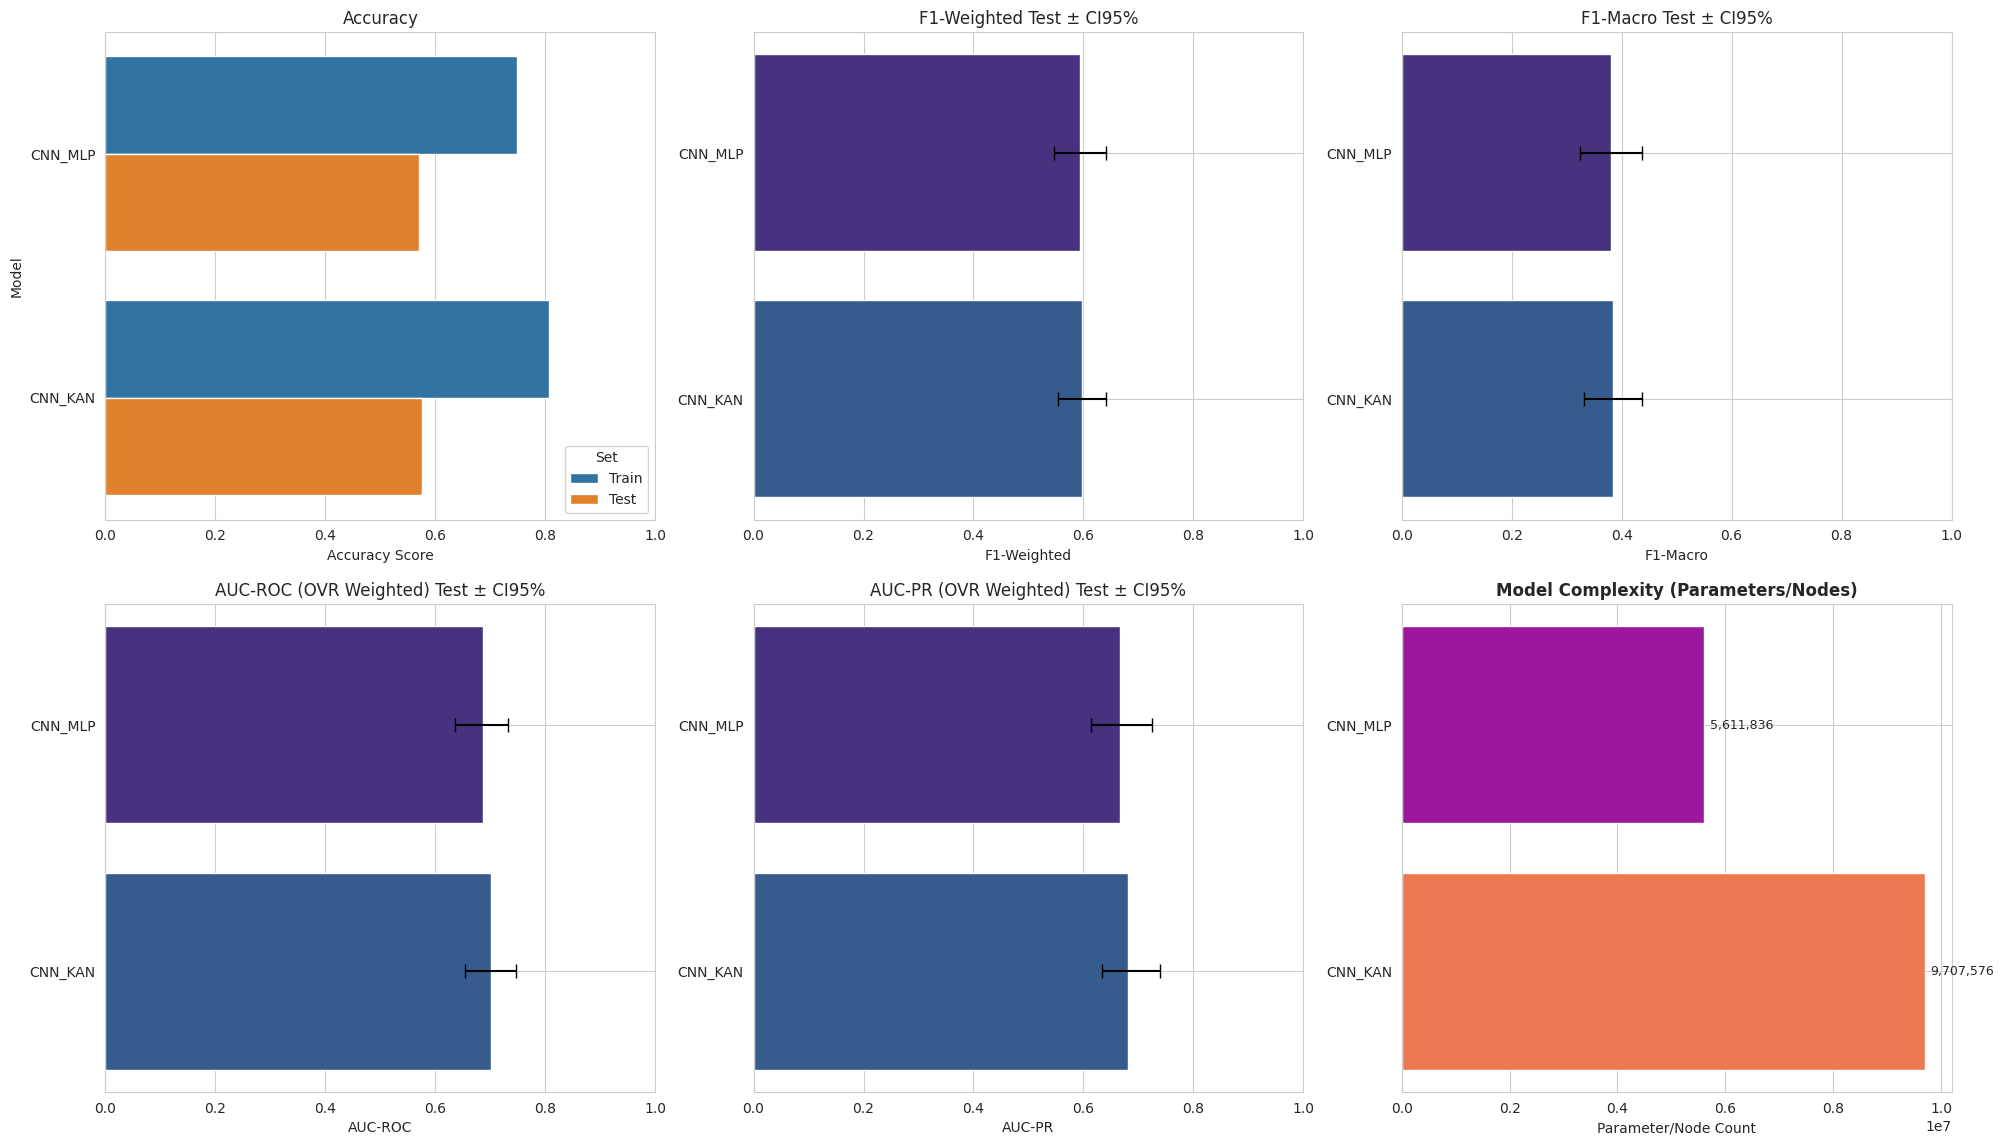

In [53]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model', 'Param_Count',
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

## Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [54]:
# 1) Define metrics and their optimization direction
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Build ranking DataFrame
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Param_Count'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Param_Count'] = df_ranks['Param_Count']

for method_name, score_col in methods.items():
    best_model = ranks[score_col].idxmin() if 'pareto' not in score_col else ranks[score_col].idxmin()
    best_score = ranks.loc[best_model, score_col]
    results_summary[method_name] = ranks[score_col]
    print(f"{method_name:25} -> {best_model:15} (score: {best_score:.3f})")

print("\n" + "="*70)
print("DETAILED RANKING TABLE")
print("="*70)

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Param_Count'] = df_ranks['Param_Count'].astype(int)
ranking_display['Avg_Performance'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
display(ranking_display_sorted)

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Param_Count']
recommended_f1_score = df_ranks.loc[recommended_model, 'F1_Weighted_Test']

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   Reason: Best balance between performance and complexity")
print(f"   Parameters: {int(recommended_params):,}")
print(f"   F1-Weighted Score: {recommended_f1_score:.4f}")
print(f"   Complexity-Weighted Rank Score: {recommended_score:.3f}")

# Show top 3 models for comparison
print(f"\n  TOP 3 MODELS (Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Param_Count'])
    current_f1_score = df_ranks.loc[model, 'F1_Weighted_Test']
    print(f"   {i}. {model:15} | Params: {params:>8,} | F1: {current_f1_score:.4f} | Score: {row['complexity_weighted_score']:.3f}")

Equal Weight (1:1)        -> CNN_MLP         (score: 3.000)
Complexity Weighted (1:2) -> CNN_MLP         (score: 4.000)
Extreme Complexity (1:3)  -> CNN_MLP         (score: 5.000)
Pareto Approach (40:60)   -> CNN_MLP         (score: 0.400)

DETAILED RANKING TABLE


,Param_Count,Avg_Performance,Complexity_Rank,Equal_Rank,Extreme_Rank,Pareto_Rank
Model,,,,,,
CNN_MLP,5611836,2.0,1,1,1,1
CNN_KAN,9707576,1.0,2,1,2,2



RECOMMENDATION
   RECOMMENDED MODEL: CNN_MLP
   Reason: Best balance between performance and complexity
   Parameters: 5,611,836
   F1-Weighted Score: 0.5936
   Complexity-Weighted Rank Score: 4.000

  TOP 3 MODELS (Complexity-Weighted Ranking):
   1. CNN_MLP         | Params: 5,611,836 | F1: 0.5936 | Score: 4.000
   2. CNN_KAN         | Params: 9,707,576 | F1: 0.5973 | Score: 5.000


## Ablation Study with Post-Training Pruning

In [65]:
class PruningAblationStudy:
    def __init__(self, device='cpu'):
        self.device = device
        self.pruning_results = []

    def get_model_sparsity(self, model):
        """Calcola la sparsità globale del modello"""
        if isinstance(model, KAN):
            # Per i modelli KAN, calcola la sparsità basata sui nodi/edge attivi
            # dopo il pruning con .prune()
            try:
                original_params = count_params(model)
                if original_params == 0:
                    return 0.0

                # Conta i parametri rimasti dopo pruning
                active_params = 0
                for i in range(len(model.width) - 1):
                    layer = model.act_fun[i]
                    # Conta i nodi/edge non pruned in questo layer
                    if hasattr(layer, 'mask'):
                        active_params += torch.sum(layer.mask).item()
                    else:
                        # Se non c'è mask, assumiamo tutti attivi
                        a = model.width[i] if not isinstance(model.width[i], list) else model.width[i][0]
                        b = model.width[i+1] if not isinstance(model.width[i+1], list) else model.width[i+1][0]
                        active_params += a * b

                # Stima della sparsità approssimativa
                total_connections = sum(model.width[i] * model.width[i+1] for i in range(len(model.width)-1))
                if total_connections > 0:
                    return 1.0 - (active_params / total_connections)
                return 0.0

            except Exception as e:
                print(f"  Error calculating KAN sparsity: {e}")
                return 0.0
        else:
            # Per modelli PyTorch standard
            zero_params = 0
            total_params = 0

            for module in model.modules():
                if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
                    if hasattr(module, 'weight'):
                        zero_params += float(torch.sum(module.weight == 0))
                        total_params += float(module.weight.nelement())
                    if hasattr(module, 'bias') and module.bias is not None:
                        zero_params += float(torch.sum(module.bias == 0))
                        total_params += float(module.bias.nelement())

            return zero_params / total_params if total_params > 0 else 0.0

    def count_active_parameters(self, model):
        """Conta i parametri attivi (non pruned) nel modello usando la funzione count_params esistente"""
        if isinstance(model, KAN):
            # Per i modelli KAN dopo pruning, usa count_params che gestisce la struttura KAN
            # Il metodo .prune() di KAN modifica internamente la struttura
            return count_params(model)
        else:
            # Per modelli PyTorch standard, conta i parametri non-zero dopo pruning
            active_params = 0
            for module in model.modules():
                if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
                    if hasattr(module, 'weight'):
                        active_params += float(torch.sum(module.weight != 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        active_params += float(torch.sum(module.bias != 0))
            return int(active_params)

    def apply_magnitude_pruning(self, model, pruning_ratio):
        """Applica pruning al modello - magnitude-based per CNN, node/edge pruning per KAN"""
        pruned_model = copy.deepcopy(model)

        if isinstance(model, KAN):
            # Per modelli KAN, usa il metodo .prune() nativo che opera su nodi ed edge
            # Il threshold viene calcolato in base al pruning_ratio desiderato
            # KAN.prune() rimuove nodi/edge con bassa importanza
            try:
                # Calcola il threshold appropriato per ottenere il pruning_ratio desiderato
                # Un threshold più alto = più pruning
                if pruning_ratio == 0.0:
                    return pruned_model

                # Per KAN, il threshold è tipicamente un valore piccolo (es. 1e-2 to 1e-1)
                # Mappiamo il pruning_ratio a un range di threshold appropriato
                threshold = pruning_ratio * 0.1  # Scala il ratio a threshold range [0, 0.1]

                print(f"  Applying KAN pruning with threshold: {threshold:.6f}")
                pruned_model.prune(threshold=threshold)

                return pruned_model

            except Exception as e:
                print(f"  Error durante KAN pruning: {e}")
                print(f"  Restituisco modello originale")
                return model
        else:
            # Per modelli PyTorch standard, usa magnitude-based pruning
            modules_to_prune = []
            for name, module in pruned_model.named_modules():
                if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
                    modules_to_prune.append((module, 'weight'))
                    if hasattr(module, 'bias') and module.bias is not None:
                        modules_to_prune.append((module, 'bias'))

            # Applica pruning globale basato su magnitude
            if modules_to_prune:
                prune.global_unstructured(
                    modules_to_prune,
                    pruning_method=prune.L1Unstructured,
                    amount=pruning_ratio,
                )

                # Rendi permanente il pruning
                for module, param_name in modules_to_prune:
                    prune.remove(module, param_name)

        return pruned_model

    def evaluate_pruned_model(self, model, model_name, test_paths, test_labels,
                            train_paths, train_labels, batch_size=32):
        """Valuta le prestazioni di un modello pruned"""
        model.eval()

        # Crea dataset e dataloader
        test_dataset = ImageDataset(test_paths, test_labels)
        train_dataset = ImageDataset(train_paths, train_labels)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        # Predizioni su test set
        y_pred_test, y_true_test = [], []
        y_proba_test = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                pred = torch.argmax(outputs, dim=1)
                proba = F.softmax(outputs, dim=1)

                y_pred_test.extend(pred.cpu().numpy())
                y_true_test.extend(labels.cpu().numpy())
                y_proba_test.extend(proba.cpu().numpy())

        y_proba_test = np.array(y_proba_test)

        # Calcola metriche
        accuracy = accuracy_score(y_true_test, y_pred_test)
        f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

        # AUC metriche (con gestione errori)
        try:
            auc_roc = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')
        except ValueError:
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }

    def run_pruning_study(self, model, model_name, test_paths, test_labels,
                         train_paths, train_labels,
                         pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]):
        """
        Conduce lo studio di ablazione con diversi livelli di pruning
        """
        print(f"\n=== Pruning Ablation Study for {model_name} ===")

        # Usa la funzione count_params esistente per ottenere il numero originale di parametri
        original_params = count_params(model)

        # Entrambi i tipi di modello supportano il pruning, ma con metodi diversi
        is_kan_model = isinstance(model, KAN)
        if is_kan_model:
            print(f"NOTA: {model_name} è un modello KAN. Usando pruning nativo su nodi/edge.")
        else:
            print(f"NOTA: {model_name} è un modello CNN standard. Usando magnitude-based pruning.")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting pruning ratio: {pruning_ratio:.4f}")

            if pruning_ratio == 0.0:
                # Modello originale
                pruned_model = model
                sparsity = 0.0
                active_params = original_params
            else:
                # Applica pruning (metodo appropriato per il tipo di modello)
                pruned_model = self.apply_magnitude_pruning(model, pruning_ratio)
                sparsity = self.get_model_sparsity(pruned_model)
                active_params = self.count_active_parameters(pruned_model)

            # Valuta prestazioni
            metrics = self.evaluate_pruned_model(
                pruned_model, model_name, test_paths, test_labels,
                train_paths, train_labels
            )

            # Salva risultati
            result = {
                'model_name': model_name,
                'pruning_ratio': pruning_ratio,
                'sparsity': sparsity,
                'original_params': original_params,
                'active_params': active_params,
                'compression_ratio': original_params / active_params if active_params > 0 else float('inf'),
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Sparsity: {sparsity:.3f}")
            print(f"  Active params: {active_params:,} / {original_params:,}")
            print(f"  Compression: {result['compression_ratio']:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

    def plot_pruning_results(self, figsize=(16, 12)):
        """
        Visualizza i risultati dello studio di pruning
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Post-Training Pruning Ablation Study Results', fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("husl", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=model, color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=model, color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: Performance vs Compression Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            # Filtra valori infiniti per il plot
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=model, color=colors[i], s=50, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 4: Sparsity vs Performance
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            ax.plot(model_data['sparsity'], model_data['accuracy'],
                   marker='d', label=model, color=colors[i], linewidth=2)
        ax.set_xlabel('Model Sparsity')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Model Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 5: Active Parameters vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            ax.semilogx(model_data['active_params'], model_data['f1_weighted'],
                       marker='^', label=model, color=colors[i], linewidth=2)
        ax.set_xlabel('Active Parameters (log scale)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Active Parameters')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: Multi-metric comparison at 50% pruning
        ax = axes[1, 2]
        metrics_to_compare = ['accuracy', 'f1_weighted', 'f1_macro']
        x_pos = np.arange(len(models))
        width = 0.25

        # Prendi i dati a 50% pruning (o il più vicino disponibile)
        pruning_50_data = []
        for model in models:
            model_data = df[df['model_name'] == model]
            closest_50 = model_data.iloc[(model_data['pruning_ratio'] - 0.5).abs().argsort().iloc[:1]]
            pruning_50_data.append(closest_50.iloc[0])

        for i, metric in enumerate(metrics_to_compare):
            values = [data[metric] for data in pruning_50_data]
            ax.bar(x_pos + i*width, values, width, label=metric.replace('_', ' ').title(), alpha=0.8)

        ax.set_xlabel('Models')
        ax.set_ylabel('Score')
        ax.set_title('Performance Comparison at ~50% Pruning')
        ax.set_xticks(x_pos + width)
        ax.set_xticklabels(models)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

    def generate_pruning_report(self):
        """
        Genera un report dettagliato dei risultati del pruning
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("PRUNING ABLATION STUDY - DETAILED REPORT")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Trova il punto di degradazione significativa (>5% loss in F1)
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            degradation_point = None

            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")
            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"Best trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1-Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

Iniziando Pruning Ablation Study...
SUPPORTO PRUNING:
- CNN_MLP: Magnitude-based pruning su pesi e bias
- CNN_KAN: Native .prune() method su nodi ed edge
Entrambi i modelli supportano pruning con metodologie diverse.

Trovato modello CNN_MLP - Eseguendo magnitude-based pruning study...

=== Pruning Ablation Study for CNN_MLP ===
NOTA: CNN_MLP è un modello CNN standard. Usando magnitude-based pruning.

Testing pruning ratio: 0.0000
  Sparsity: 0.000
  Active params: 5,611,836 / 5,611,836
  Compression: 1.00x
  Accuracy: 0.5700
  F1-Weighted: 0.5936

Testing pruning ratio: 0.1000
  Sparsity: 0.100
  Active params: 5,050,652 / 5,611,836
  Compression: 1.11x
  Accuracy: 0.5700
  F1-Weighted: 0.5929

Testing pruning ratio: 0.2000
  Sparsity: 0.200
  Active params: 4,489,469 / 5,611,836
  Compression: 1.25x
  Accuracy: 0.5700
  F1-Weighted: 0.5936

Testing pruning ratio: 0.3000
  Sparsity: 0.300
  Active params: 3,928,285 / 5,611,836
  Compression: 1.43x
  Accuracy: 0.5700
  F1-Weighted: 0.5

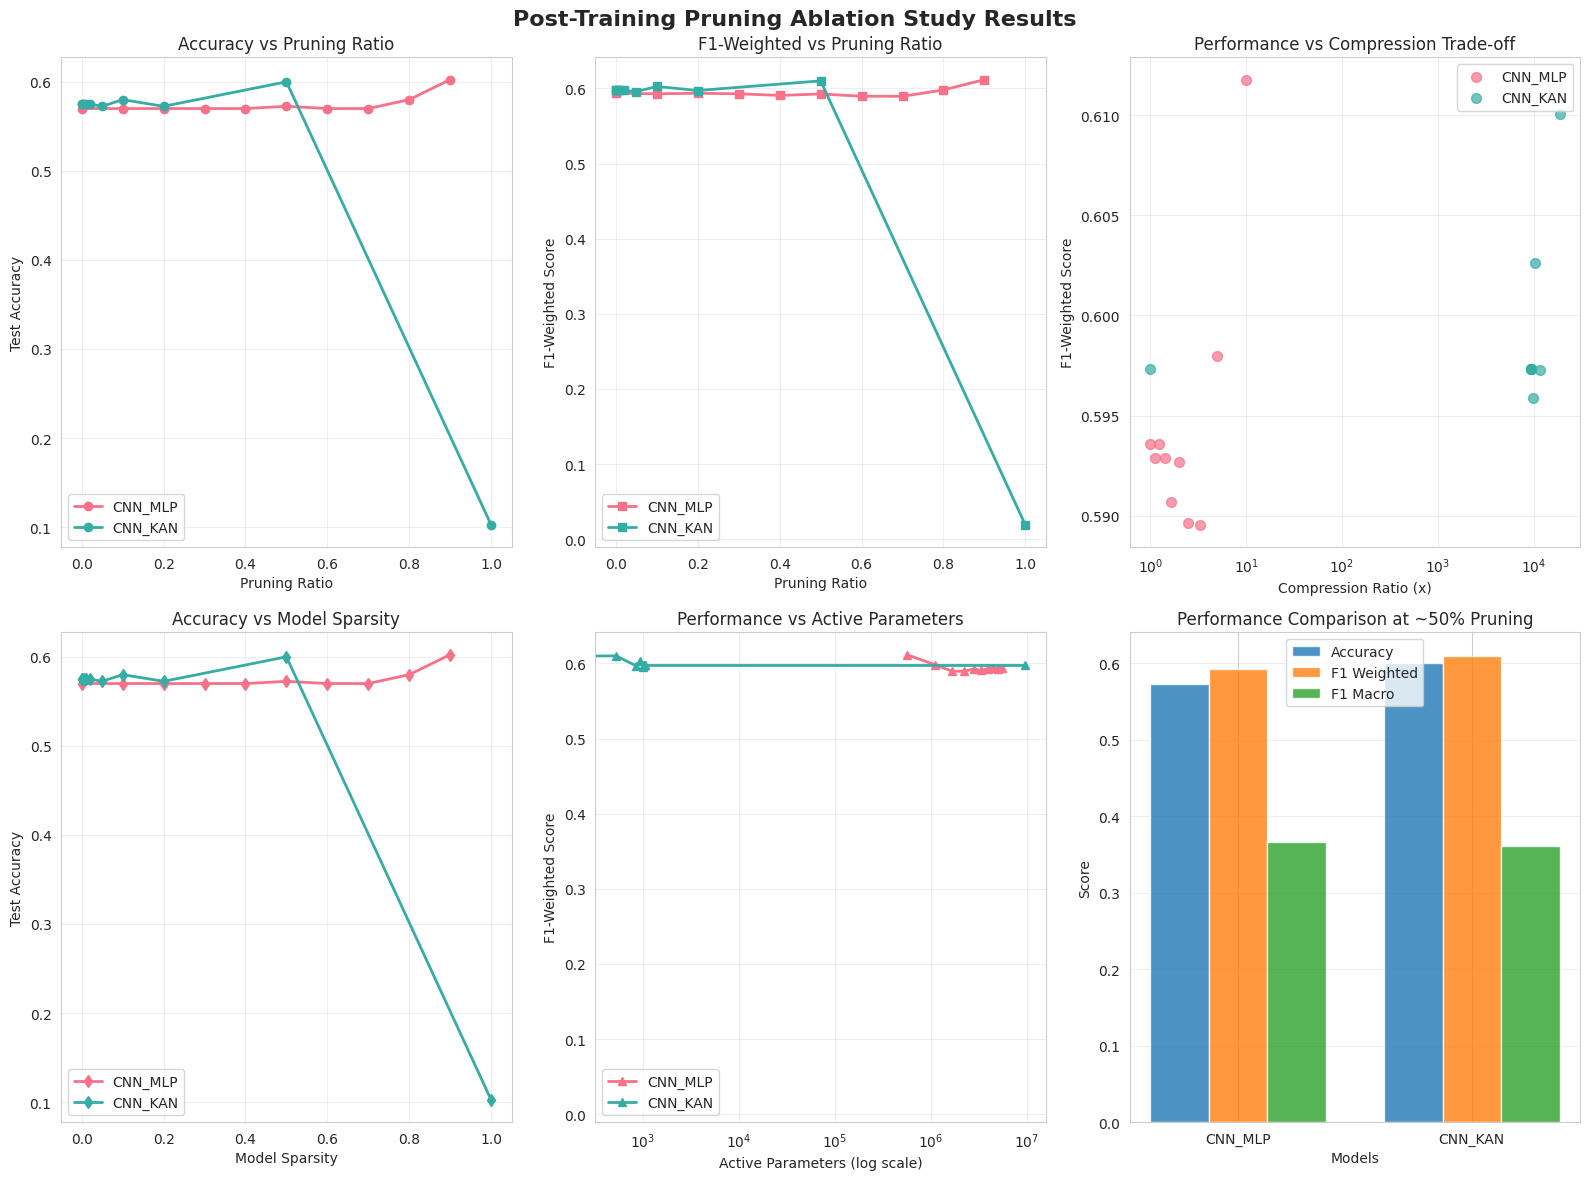


PRUNING ABLATION STUDY - DETAILED REPORT

CNN_MLP Results:
--------------------------------------------------
Baseline F1-Weighted: 0.5936
No significant degradation observed within tested range
Best trade-off point:
  Pruning ratio: 90.0%
  Compression: 10.0x
  F1-Weighted: 0.6118
  Performance loss: -3.1%

CNN_KAN Results:
--------------------------------------------------
Baseline F1-Weighted: 0.5973
Significant degradation starts at: 100.0% pruning
Best trade-off point:
  Pruning ratio: 50.0%
  Compression: 18525.9x
  F1-Weighted: 0.6101
  Performance loss: -2.1%

COMPARATIVE SUMMARY TABLE
  Model Pruning_Ratio Compression F1_Score Perf_Loss
CNN_MLP           30%        1.4x   0.5929      0.1%
CNN_MLP           50%        2.0x   0.5927      0.2%
CNN_MLP           70%        3.3x   0.5895      0.7%
CNN_MLP           90%       10.0x   0.6118     -3.1%
CNN_KAN           30%    11584.2x   0.5973      0.0%
CNN_KAN           50%    18525.9x   0.6101     -2.1%
CNN_KAN           90%      

,model_name,pruning_ratio,sparsity,original_params,active_params,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,CNN_MLP,0.000,0.000000,5611836,5611836,1.000000e+00,0.5700,0.593586,0.381195,0.685999,0.666302
1,CNN_MLP,0.100,0.100000,5611836,5050652,1.111111e+00,0.5700,0.592899,0.381591,0.685997,0.666181
2,CNN_MLP,0.200,0.200000,5611836,4489469,1.250000e+00,0.5700,0.593586,0.381195,0.685902,0.665715
3,CNN_MLP,0.300,0.300000,5611836,3928285,1.428572e+00,0.5700,0.592899,0.381591,0.686228,0.666054
4,CNN_MLP,0.400,0.400000,5611836,3367102,1.666666e+00,0.5700,0.590693,0.362489,0.686304,0.666174
5,CNN_MLP,0.500,0.500000,5611836,2805918,2.000000e+00,0.5725,0.592671,0.365980,0.686305,0.666113
6,CNN_MLP,0.600,0.600000,5611836,2244734,2.500000e+00,0.5700,0.589648,0.362295,0.686948,0.665518
7,CNN_MLP,0.700,0.700000,5611836,1683551,3.333333e+00,0.5700,0.589540,0.362891,0.687332,0.666561
8,CNN_MLP,0.800,0.800000,5611836,1122367,5.000001e+00,0.5800,0.597991,0.367220,0.687625,0.666220
9,CNN_MLP,0.900,0.900000,5611836,561184,9.999993e+00,0.6025,0.611782,0.381612,0.690317,0.668831


In [67]:
# Esegui lo studio di ablazione sui modelli migliori
print("Iniziando Pruning Ablation Study...")
print("SUPPORTO PRUNING:")
print("- CNN_MLP: Magnitude-based pruning su pesi e bias")
print("- CNN_KAN: Native .prune() method su nodi ed edge")
print("Entrambi i modelli supportano pruning con metodologie diverse.\n")

# Inizializza la classe per lo studio
pruning_study = PruningAblationStudy(device=device)

# Definisci i livelli di pruning da testare
pruning_ratios_mlp_cnn = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# The automatic pruning process in KANs works as follows: For each node, the maximum L1 norm of its incoming and outgoing activations is calculated.
# If both the maximum incoming and outgoing L1 norms are below a certain threshold, the node is considered inactive and pruned away.
# However, automatic edge pruning is not performed to avoid accidentally removing important edges with small L1 norms.
pruning_ratios_kan_cnn = [0.0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]

# Esegui pruning study su CNN_MLP
if 'best_cnn_mlp' in locals():
    print("Trovato modello CNN_MLP - Eseguendo magnitude-based pruning study...")
    pruning_study.run_pruning_study(
        model=best_cnn_mlp,
        model_name='CNN_MLP',
        test_paths=test_paths,
        test_labels=test_labels,
        train_paths=train_paths,
        train_labels=train_labels,
        pruning_ratios=pruning_ratios_mlp_cnn
    )

# Esegui pruning study su CNN_KAN
if 'best_cnn_kan' in locals():
    print("Trovato modello CNN_KAN - Eseguendo node/edge pruning study...")
    pruning_study.run_pruning_study(
        model=best_cnn_kan,
        model_name='CNN_KAN',
        test_paths=test_paths,
        test_labels=test_labels,
        train_paths=train_paths,
        train_labels=train_labels,
        pruning_ratios=pruning_ratios_kan_cnn
    )

# Visualizza i risultati
pruning_study.plot_pruning_results()

# Genera report dettagliato
pruning_study.generate_pruning_report()

# Salva i risultati in DataFrame per ulteriori analisi
pruning_results_df = pd.DataFrame(pruning_study.pruning_results)
print(f"\nPruning results saved to 'pruning_results_df' with {len(pruning_results_df)} entries")
print("\nPruning results:")
display(pruning_results_df)